In [ ]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8 MB 8.6 MB/s 
     |████████████████████████████████| 145 kB 55.3 MB/s 
     |████████████████████████████████| 181 kB 64.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [ ]:
!pip install wandb
!pip install wordcloud
!pip install colour

In [ ]:
## Installing font for Hindi for matplotlib ##
!apt-get install -y fonts-lohit-deva
!fc-list :lang=hi family

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  fonts-lohit-deva
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 78.2 kB of archives.
After this operation, 196 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 fonts-lohit-deva all 2.95.4-2 [78.2 kB]
Fetched 78.2 kB in 0s (266 kB/s)
Selecting previously unselected package fonts-lohit-deva.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../fonts-lohit-deva_2.95.4-2_all.deb ...
Unpacking fonts-lohit-deva (2.95.4-2) ...
Setting up fonts-lohit-deva (2.95.4-2) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
Lohit Devanagari


In [ ]:
!nvidia-smi

Sat May 14 16:58:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
import os
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import random
import time
import tensorflow as tf
from tensorflow import GradientTape
from tensorflow import keras
import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, SimpleRNNCell, LSTMCell, GRUCell
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from sklearn.utils import shuffle
import wandb
import csv
from sklearn.metrics import confusion_matrix
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from colour import Color
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!curl https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar --output dakshina_dataset_v1.0.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1915M  100 1915M    0     0   219M      0  0:00:08  0:00:08 --:--:--  230M


In [ ]:
%%capture
!tar -xvf  'dakshina_dataset_v1.0.tar'

In [ ]:
%cd '/content/dakshina_dataset_v1.0/'

/content/dakshina_dataset_v1.0


In [ ]:
val_df = pd.read_csv("./hi/lexicons/hi.translit.sampled.dev.tsv", sep='\t', header=None)
# Number of training examples
M_train = len(val_df.keys())
train_df = pd.read_csv("./hi/lexicons/hi.translit.sampled.train.tsv", sep='\t', header=None)
# Number of validation examples
M_val = len(train_df.keys())
test_df = pd.read_csv("./hi/lexicons/hi.translit.sampled.test.tsv", sep='\t', header=None)
# Number of test examples
M_test = len(test_df.keys())

print(f"Number of training examples = {M_train}")
print(f"Number of validation examples = {M_val}")
print(f"Number of test examples = {M_test}")
print()
print("Data Loaded to Dataframes!")

Number of training examples = 3
Number of validation examples = 3
Number of test examples = 3

Data Loaded to Dataframes!


In [ ]:
%cd '/content/drive/My Drive/checkpoint2/'

/content/drive/My Drive/checkpoint2


In [ ]:
!pwd


/content/drive/My Drive/checkpoint2


In [ ]:
train_df.sample(n=3)

,0,1,2
32776,योनि,yoni,5
36411,विक्टोरियाई,victoriyai,1
11011,गौरवमयी,gauravmayi,3


In [ ]:
sos = "@"
eos = "#"

In [ ]:
class LexDataset:
    def __init__(self, input_tensor, target_tensor, batch_size):
        self.input_tensor = input_tensor
        self.target_tensor = target_tensor
        self.batch = tf.data.Dataset.from_tensor_slices((self.input_tensor, self.target_tensor)).shuffle(len(self.input_tensor)).batch(batch_size, drop_remainder=True)

In [ ]:
class TransliterationDatatset:
    def __init__(self, df_list, batch_size = 64):
        
        self.input_tokenizer = None
        self.target_tokenizer = None
        self.train = None
        self.val = None
        self.test = None
        self.batch_size = batch_size
        # Load Data
        self.load_dataset(df_list)
        # Other parameters
        self.num_input_tokens = len(self.input_tokenizer.index_word)+1
        self.num_target_tokens = len(self.target_tokenizer.index_word)+1
        self.max_input_seq_length = np.max([self.train.input_tensor.shape[1], self.val.input_tensor.shape[1], self.test.input_tensor.shape[1]])
        self.max_target_seq_length = np.max([self.train.target_tensor.shape[1], self.val.target_tensor.shape[1], self.test.target_tensor.shape[1]])
        
    def preprocess_word(self, w):
        return sos + str(w) + eos
    
    def print_input(self, tensor):
        for t in tensor:
            if t != 0:
                print(f'{t} ----> {self.input_tokenizer.index_word[t]}')
                
    def print_target(self, tensor):
        for t in tensor:
            if t != 0:
                print(f'{t} ----> {self.target_tokenizer.index_word[t]}')
    
    def create_dataset(self, data_frame):
        input_words = []
        target_words = []
        # Shuffle the data_frame before creating dataset
        df = data_frame
        for i in range(5):
            df = shuffle(df)
        for x, y in zip(df[1], df[0]):
            input_words.append(self.preprocess_word(x))
            target_words.append(self.preprocess_word(y))
        return (input_words, target_words)
    
    def load_dataset(self, df_list):
        # df_list should have train -> val -> test in sequence
        
        self.input_tokenizer = Tokenizer(num_words = None, char_level = True)
        self.target_tokenizer = Tokenizer(num_words = None, char_level = True)
        
        ds_list = []
        
        for df in df_list:
            # Get the words list
            (input_words, target_words) = self.create_dataset(df)
            # Fit on the set of words
            self.input_tokenizer.fit_on_texts(input_words)
            self.target_tokenizer.fit_on_texts(target_words)
            ds_list.append((input_words, target_words))
                    
        self.target_tokenizer.index_word.update({0:" "})
        self.input_tokenizer.index_word.update({0:" "})
        
        input_word_len = []
        target_word_len = []
        
        tensor_list = []
        
        for i, (input_words, target_words) in enumerate(ds_list):
            input_tensor = self.input_tokenizer.texts_to_sequences(input_words)
            target_tensor = self.target_tokenizer.texts_to_sequences(target_words)
            tensor_list.append((input_tensor, target_tensor))
            input_word_len.append(np.max([len(x) for x in input_tensor]))
            target_word_len.append(np.max([len(x) for x in target_tensor]))
        
        for i, (input_tensor, target_tensor) in enumerate(tensor_list):
            
            input_tensor = pad_sequences(input_tensor, padding='post', maxlen = np.max(input_word_len))
            target_tensor = pad_sequences(target_tensor, padding='post', maxlen = np.max(target_word_len))
            
            if i == 0:
                self.train = LexDataset(input_tensor, target_tensor, self.batch_size)
            elif i == 1:
                self.val = LexDataset(input_tensor, target_tensor, self.batch_size)
            else:
                self.test = LexDataset(input_tensor, target_tensor, self.batch_size)

In [ ]:
dataset = TransliterationDatatset([train_df, val_df, test_df], 128)

In [ ]:
# Training data
dataset.train.input_tensor.shape, dataset.train.target_tensor.shape

((44204, 22), (44204, 21))

In [ ]:
# Validation data
dataset.val.input_tensor.shape, dataset.val.target_tensor.shape

((4358, 22), (4358, 21))

In [ ]:
# Test data
dataset.test.input_tensor.shape, dataset.test.target_tensor.shape

((4502, 22), (4502, 21))

In [ ]:
# Number of tokens
dataset.num_input_tokens, dataset.num_target_tokens

(30, 67)

In [ ]:
# max seq length
dataset.max_input_seq_length, dataset.max_target_seq_length

(22, 21)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset.train.batch))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 22]), TensorShape([128, 21]))

In [ ]:
dataset.print_input(example_input_batch[2].numpy())

2 ----> @
9 ----> s
16 ----> m
10 ----> e
14 ----> l
14 ----> l
3 ----> #


In [ ]:
dataset.print_target(example_target_batch[2].numpy())

1 ----> @
9 ----> स
5 ----> ्
15 ----> म
14 ----> े
13 ----> ल
2 ----> #


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout=0.1, layer_type="GRU"):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.layer_type = layer_type

        ##-------- RNN layer in Encoder ------- ##
        if self.layer_type == "LSTM":
            self.layer = LSTM(self.enc_units,return_sequences=True,return_state=True,dropout = dropout,recurrent_initializer='glorot_uniform')
            
        elif self.layer_type == "GRU":
            self.layer = GRU(self.enc_units,return_sequences=True,return_state=True,dropout = dropout,recurrent_initializer='glorot_uniform')
           
        else:
            self.layer = SimpleRNN(self.enc_units,return_sequences=True,return_state=True,dropout = dropout,recurrent_initializer='glorot_uniform')

    def call(self, inputs, hidden):
        inputs = self.embedding(inputs)
        if self.layer_type == "LSTM":
            output, h, c = self.layer(inputs, initial_state = hidden)
            return output, h, c
        else:
            output, h = self.layer(inputs, initial_state = hidden)
            return output, h, None

    def initialize_hidden_state(self, batch_size):
        if self.layer_type == "LSTM":
            return [tf.zeros((batch_size, self.enc_units)), tf.zeros((batch_size, self.enc_units))]
        else:
            return tf.zeros((batch_size, self.enc_units))

In [ ]:
vocab_inp_size = dataset.num_input_tokens
embedding_dim = 64
units = 256
BATCH_SIZE = dataset.batch_size

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state(BATCH_SIZE)
sample_output, sample_hidden, _ = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (128, 22, 256)
Encoder Hidden state shape: (batch size, units) (128, 256)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (128, 256)
Attention weights shape: (batch_size, sequence_length, 1) (128, 22, 1)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dropout=0.1, layer_type="GRU"):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.layer_type = layer_type
        
        ##-------- RNN layer in Decoder ------- ##
        if self.layer_type == "LSTM":
            self.layer = LSTM(self.dec_units,return_sequences=True,return_state=True,dropout = dropout,recurrent_initializer='glorot_uniform')
            
        elif self.layer_type == "GRU":
            self.layer = GRU(self.dec_units,return_sequences=True,return_state=True,dropout = dropout,recurrent_initializer='glorot_uniform')
           
        else:
            self.layer = SimpleRNN(self.dec_units,return_sequences=True,return_state=True,dropout = dropout,recurrent_initializer='glorot_uniform')
        
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU/LSTM/SimpleRNN
        if self.layer_type != "LSTM":
            output, state_h = self.layer(x)
        else:
            output, state_h, state_c = self.layer(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        # return x, state
        if self.layer_type != "LSTM":
            return x, state_h, None, attention_weights
        else:
            return x, state_h, state_c, attention_weights

In [ ]:
vocab_tar_size = dataset.num_target_tokens

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (128, 67)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
def accuracy(real, pred):
    real = tf.cast(real, tf.int32)
    pred = tf.cast(pred, tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(real, pred), tf.float32))

In [ ]:
def train_one_step():
    @tf.function
    def train_step(encoder, decoder, inp, targ, enc_hidden, is_val=False):
        loss = 0

        with tf.GradientTape() as tape:
            enc_output, enc_hidden, enc_cell = encoder(inp, enc_hidden)

            dec_hidden, dec_cell = enc_hidden, enc_cell

            dec_input = tf.expand_dims([dataset.target_tokenizer.word_index[sos]] * inp.shape[0], 1)

            pred = None

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _, _ = decoder(dec_input, dec_hidden, enc_output)

                loss += loss_function(targ[:, t], predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)

                if t == 1:
                    pred = tf.expand_dims(tf.argmax(predictions, axis=-1), 1)
                else:
                    pred = tf.concat([pred, tf.expand_dims(tf.argmax(predictions, axis=-1), 1)], 1)

        batch_loss = (loss / int(targ.shape[1]))
        batch_accuracy = accuracy(targ[:, 1:], pred)

        if not is_val:
            variables = encoder.trainable_variables + decoder.trainable_variables

            gradients = tape.gradient(loss, variables)

            optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, batch_accuracy
    return train_step

In [ ]:
default_config = {
    "layer_type": "GRU",
    "units": 256,
    "embedding_dim": 64,
    "optimiser": "nadam",
    "epochs": 20,
    "dropout": 0.1,
    "batch_size": dataset.batch_size,
    "num_layers": 1,
    "has_attention": True
}

In [ ]:
def log_wandb(data):
    wandb.log(data)

In [ ]:
sweep_config = {
    "name": "With Attention Single Layered " + str(datetime.datetime.now().replace(microsecond=0).isoformat()),
    "method": "random",
    "metric":{
        "name": "loss",
        "goal": "minimize"
    },
    "project": 'Assignment 3',
    "parameters": {
        "layer_type": {
            "values": ["GRU", "LSTM", "SimpleRNN"]
        },
        "dropout": {
            "values": [0.0, 0.1]
        },
        "units": {
            "values": [256, 512]
        },
        "embedding_dim": {
            "values": [64, 128]
        },
        "optimiser": {
            "values": ["nadam"]
        },
        "epochs": {
            "values": [20]
        },
        "batch_size": {
            "values": [dataset.batch_size]
        },
        "num_layers": {
            "values": [1]
        },
        "has_attention": {
            "values": [True]
        }
    }
}

In [ ]:
def train(dataset, config, callback=None):

    run_name = "".join(f"{a}:{b} " for (a, b) in config.items())
    print(run_name)
    # wandb.run.name = run_name

    train_dataset = dataset.train
    val_dataset = dataset.val

    EPOCHS = config["epochs"]
    BATCH_SIZE = config["batch_size"]
    steps_per_epoch = len(train_dataset.input_tensor)//BATCH_SIZE
    val_steps_per_epoch = len(val_dataset.input_tensor)//BATCH_SIZE
    embedding_dim = config["embedding_dim"]     
    units = config["units"]
    layer_type = config["layer_type"]
    num_layers = config["num_layers"]
    dropout = config["dropout"]

    # Encoder
    encoder = Encoder(dataset.num_input_tokens, embedding_dim, units, BATCH_SIZE, dropout, layer_type)
    # Decoder
    decoder = Decoder(dataset.num_target_tokens, embedding_dim, units, BATCH_SIZE, dropout, layer_type)

    train_step = train_one_step()

    for epoch in range(EPOCHS):
        start = time.time()

        enc_hidden = encoder.initialize_hidden_state(BATCH_SIZE)
        total_loss = 0
        total_accuracy = 0
        val_total_loss = 0
        val_total_accuracy = 0

        train_dataset.batch.shuffle(BATCH_SIZE*10)

        for (batch, (inp, targ)) in enumerate(train_dataset.batch.take(steps_per_epoch)):
            # Step Train
            batch_loss, batch_accuracy = train_step(encoder, decoder, inp, targ, enc_hidden)
            total_loss += batch_loss
            total_accuracy += batch_accuracy
            if batch % 100 == 0 or batch == steps_per_epoch-1:
                print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f} Accuracy {batch_accuracy:.4f}')
            
            if callback != None:
                callback({"attn epoch":epoch+1, "attn loss": batch_loss.numpy(), "attn accuracy":batch_accuracy})

        print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f} Acc {total_accuracy/steps_per_epoch:.4f}')
        print(f'Time taken for 1 epoch {time.time()-start:.4f} sec\n')
        if callback != None:
            callback({"ep attn loss": total_loss/steps_per_epoch, "ep attn accuracy": total_accuracy/steps_per_epoch})

        val_dataset.batch.shuffle(BATCH_SIZE*10)
        start = time.time()

        for (batch, (inp, targ)) in enumerate(val_dataset.batch.take(val_steps_per_epoch)):
            val_batch_loss, val_batch_accuracy = train_step(encoder, decoder, inp, targ, enc_hidden, True)
            val_total_loss += val_batch_loss
            val_total_accuracy += val_batch_accuracy

            if batch % 100 == 0 or batch == val_steps_per_epoch-1:
                print(f'Epoch {epoch+1} Batch {batch} Val Loss {val_batch_loss.numpy():.4f} Val Accuracy {val_batch_accuracy:.4f}')

            if callback != None:
                callback({"epoch":epoch+1, "attn val loss": batch_loss.numpy(), "attn val accuracy":batch_accuracy})

        print(f'Epoch {epoch+1} Val Loss {val_total_loss/val_steps_per_epoch:.4f} Val Acc {val_total_accuracy/val_steps_per_epoch:.4f}')
        print(f'Time taken for 1 epoch {time.time()-start:.4f} sec\n')

        if callback != None:
            callback({"ep attn val loss": val_total_loss/val_steps_per_epoch, "ep attn val accuracy": val_total_accuracy/val_steps_per_epoch})

    return encoder, decoder

In [ ]:
enc, dec = train(dataset, default_config)

layer_type:GRU units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4252 Accuracy 0.0039
Epoch 1 Batch 100 Loss 1.0456 Accuracy 0.0691
Epoch 1 Batch 200 Loss 1.0081 Accuracy 0.0980
Epoch 1 Batch 300 Loss 0.8809 Accuracy 0.1008
Epoch 1 Batch 344 Loss 0.8874 Accuracy 0.1059
Epoch 1 Loss 1.0152 Acc 0.0821
Time taken for 1 epoch 46.3804 sec

Epoch 1 Batch 0 Val Loss 0.8387 Val Accuracy 0.0945
Epoch 1 Batch 33 Val Loss 0.8393 Val Accuracy 0.0930
Epoch 1 Val Loss 0.8609 Val Acc 0.0978
Time taken for 1 epoch 9.6567 sec

Epoch 2 Batch 0 Loss 0.9495 Accuracy 0.1121
Epoch 2 Batch 100 Loss 0.8368 Accuracy 0.0969
Epoch 2 Batch 200 Loss 0.8437 Accuracy 0.1238
Epoch 2 Batch 300 Loss 0.6742 Accuracy 0.1508
Epoch 2 Batch 344 Loss 0.6584 Accuracy 0.1676
Epoch 2 Loss 0.8117 Acc 0.1247
Time taken for 1 epoch 13.5576 sec

Epoch 2 Batch 0 Val Loss 0.6249 Val Accuracy 0.1633
Epoch 2 Batch 33 Val Loss 0.6047 Val Accuracy 0.169

In [ ]:
def sweep():

    wandb.init(config=default_config, magic=True, project="a3_collab", entity="cs21m002")
    config = wandb.config
    
    encoder, decoder = train(dataset, config, log_wandb)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="a3_collab", entity="cs21m002")

Create sweep with ID: dku188fb
Sweep URL: https://wandb.ai/cs21m002/a3_collab/sweeps/dku188fb


In [ ]:
#wandb.agent(sweep_id, function=sweep, project="a3_collab", entity="cs21m002", count=50)

wandb: Agent Starting Run: a9kqjl63 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: Currently logged in as: cs21m002. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4891 Accuracy 0.0070
Epoch 1 Batch 100 Loss 1.0049 Accuracy 0.0824
Epoch 1 Batch 200 Loss 0.9904 Accuracy 0.0867
Epoch 1 Batch 300 Loss 0.8695 Accuracy 0.1129
Epoch 1 Batch 344 Loss 0.8433 Accuracy 0.1070
Epoch 1 Loss 0.9663 Acc 0.0874
Time taken for 1 epoch 42.0903 sec

Epoch 1 Batch 0 Val Loss 0.8438 Val Accuracy 0.1168
Epoch 1 Batch 33 Val Loss 0.7684 Val Accuracy 0.1168
Epoch 1 Val Loss 0.8159 Val Acc 0.1096
Time taken for 1 epoch 8.9249 sec

Epoch 2 Batch 0 Loss 0.8173 Accuracy 0.1078
Epoch 2 Batch 100 Loss 0.7265 Accuracy 0.1270
Epoch 2 Batch 200 Loss 0.6120 Accuracy 0.1750
Epoch 2 Batch 300 Loss 0.5121 Accuracy 0.2020
Epoch 2 Batch 344 Loss 0.4305 Accuracy 0.2316
Epoch 2 Loss 0.6483 Acc 0.1665
Time taken for 1 epoch 15.1839 sec

Epoch 2 Batch 0 Val Loss 0.4404 Val Accuracy 0.2219
Epoch 2 Batch 33 Val Loss 0.4644 Val Accuracy 0.22

attn accuracy,▁▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇█▇▇██▇█▇█▇▇▇█▇▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▇▅▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▅▅▇▇▇▇▇▇▇▇▇▇██████████████████▇▇████▇▇
attn val loss,██▄▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▃▆▇▇▇▇▇████████████
ep attn loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▇▇████████████████
ep attn val loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.31523


wandb: Agent Starting Run: xj4ghx1z with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4815 Accuracy 0.0047
Epoch 1 Batch 100 Loss 0.9134 Accuracy 0.0934
Epoch 1 Batch 200 Loss 0.9045 Accuracy 0.1012
Epoch 1 Batch 300 Loss 0.9326 Accuracy 0.0961
Epoch 1 Batch 344 Loss 0.9412 Accuracy 0.1035
Epoch 1 Loss 0.9658 Acc 0.0890
Time taken for 1 epoch 33.2713 sec

Epoch 1 Batch 0 Val Loss 0.9053 Val Accuracy 0.1016
Epoch 1 Batch 33 Val Loss 0.8940 Val Accuracy 0.0984
Epoch 1 Val Loss 0.8609 Val Acc 0.1014
Time taken for 1 epoch 4.0475 sec

Epoch 2 Batch 0 Loss 0.9012 Accuracy 0.1207
Epoch 2 Batch 100 Loss 0.8579 Accuracy 0.1133
Epoch 2 Batch 200 Loss 0.9344 Accuracy 0.1125
Epoch 2 Batch 300 Loss 0.8264 Accuracy 0.1223
Epoch 2 Batch 344 Loss 0.8162 Accuracy 0.1344
Epoch 2 Loss 0.8558 Acc 0.1148
Time taken for 1 epoch 17.9456 sec

Epoch 2 Batch 0 Val Loss 0.8047 Val Accuracy 0.1187
Epoch 2 Batch 33 Val Loss 0.7763 Val Accuracy 0

attn accuracy,▁▂▂▂▂▃▃▃▃▃▄▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▂▂▃▃▂▂▄▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████▇▇▇▇
attn val loss,██▇▇▆▆▆▆▆▆▅▅▄▄▄▄▃▃▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▃▃▃▄▄▅▆▆▇▇▇███████
ep attn loss,█▇▆▆▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▂▂▃▃▃▄▅▆▇▇▇█▇██████
ep attn val loss,█▇▆▆▆▅▅▄▃▂▂▂▁▂▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.30156


wandb: Agent Starting Run: o9ilqjk9 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4405 Accuracy 0.0074
Epoch 1 Batch 100 Loss 0.8930 Accuracy 0.1023
Epoch 1 Batch 200 Loss 0.5052 Accuracy 0.1969
Epoch 1 Batch 300 Loss 0.3006 Accuracy 0.2535
Epoch 1 Batch 344 Loss 0.2293 Accuracy 0.2848
Epoch 1 Loss 0.6686 Acc 0.1708
Time taken for 1 epoch 38.8894 sec

Epoch 1 Batch 0 Val Loss 0.2544 Val Accuracy 0.2633
Epoch 1 Batch 33 Val Loss 0.2672 Val Accuracy 0.2688
Epoch 1 Val Loss 0.2601 Val Acc 0.2667
Time taken for 1 epoch 7.9555 sec

Epoch 2 Batch 0 Loss 0.2281 Accuracy 0.2754
Epoch 2 Batch 100 Loss 0.2510 Accuracy 0.2836
Epoch 2 Batch 200 Loss 0.2103 Accuracy 0.2879
Epoch 2 Batch 300 Loss 0.2090 Accuracy 0.2891
Epoch 2 Batch 344 Loss 0.1860 Accuracy 0.2898
Epoch 2 Loss 0.2166 Acc 0.2926
Time taken for 1 epoch 14.5253 sec

Epoch 2 Batch 0 Val Loss 0.1844 Val Accuracy 0.2871
Epoch 2 Batch 33 Val Loss 0.1781 Val Accuracy 0.2758

attn accuracy,▁▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇█▇▇▇███████▇▇▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▆▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▄▄▂▂▄▄▅▅▆▆▅▅▇▇▅▅▅▅▆▆▇▇▇▇██▆▆██▇▇▇▇▇▇
attn val loss,██▆▆▅▅▆▆▅▅▄▄▃▃▃▃▂▂▃▃▂▂▂▂▁▁▂▂▁▁▂▂▁▁▂▂▁▁▂▂
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇██████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▆▇▇▇█████████████
ep attn val loss,█▄▃▃▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34062


wandb: Agent Starting Run: y6nl6wor with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4532 Accuracy 0.0055
Epoch 1 Batch 100 Loss 0.9268 Accuracy 0.0984
Epoch 1 Batch 200 Loss 0.3836 Accuracy 0.2324
Epoch 1 Batch 300 Loss 0.2880 Accuracy 0.2707
Epoch 1 Batch 344 Loss 0.2816 Accuracy 0.2766
Epoch 1 Loss 0.6304 Acc 0.1800
Time taken for 1 epoch 39.5505 sec

Epoch 1 Batch 0 Val Loss 0.2628 Val Accuracy 0.2617
Epoch 1 Batch 33 Val Loss 0.2770 Val Accuracy 0.2660
Epoch 1 Val Loss 0.2626 Val Acc 0.2643
Time taken for 1 epoch 8.0473 sec

Epoch 2 Batch 0 Loss 0.2630 Accuracy 0.2859
Epoch 2 Batch 100 Loss 0.2284 Accuracy 0.2875
Epoch 2 Batch 200 Loss 0.2134 Accuracy 0.3055
Epoch 2 Batch 300 Loss 0.1933 Accuracy 0.3047
Epoch 2 Batch 344 Loss 0.1812 Accuracy 0.2930
Epoch 2 Loss 0.2196 Acc 0.2911
Time taken for 1 epoch 14.2462 sec

Epoch 2 Batch 0 Val Loss 0.2160 Val Accuracy 0.2703
Epoch 2 Batch 33 Val Loss 0.1992 Val Accuracy 0.281

attn accuracy,▁▄▆▇▆▆▆▇▇▇▇▇▇▇█▇▇▆▇▇▇██▇▇▇▇█▇████▇██▇██▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
attn val accuracy,▁▁▂▂▅▅▃▃▅▅▅▅▅▅▄▄▆▆▆▆▇▇▆▆▆▆▇▇▅▅▆▆██▇▇▆▆▇▇
attn val loss,██▅▅▄▄▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇██████████
ep attn loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▅▇▇▇██▇████████▇██
ep attn val loss,█▄▃▂▂▁▁▁▂▁▁▁▁▁▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34766


wandb: Agent Starting Run: w4qenj07 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4327 Accuracy 0.0031
Epoch 1 Batch 100 Loss 0.8939 Accuracy 0.1070
Epoch 1 Batch 200 Loss 0.4383 Accuracy 0.2336
Epoch 1 Batch 300 Loss 0.2853 Accuracy 0.2824
Epoch 1 Batch 344 Loss 0.2420 Accuracy 0.2781
Epoch 1 Loss 0.6213 Acc 0.1832
Time taken for 1 epoch 39.1405 sec

Epoch 1 Batch 0 Val Loss 0.2169 Val Accuracy 0.2785
Epoch 1 Batch 33 Val Loss 0.2238 Val Accuracy 0.2621
Epoch 1 Val Loss 0.2420 Val Acc 0.2707
Time taken for 1 epoch 7.9660 sec

Epoch 2 Batch 0 Loss 0.2186 Accuracy 0.2844
Epoch 2 Batch 100 Loss 0.1895 Accuracy 0.2863
Epoch 2 Batch 200 Loss 0.1917 Accuracy 0.3063
Epoch 2 Batch 300 Loss 0.1874 Accuracy 0.2922
Epoch 2 Batch 344 Loss 0.1771 Accuracy 0.3043
Epoch 2 Loss 0.2084 Acc 0.2941
Time taken for 1 epoch 13.9015 sec

Epoch 2 Batch 0 Val Loss 0.1580 Val Accuracy 0.2859
Epoch 2 Batch 33 Val Loss 0.1772 Val Accuracy 0.2906

attn accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇████▇███▇██▇█▇▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▃▃▄▄▄▄▅▅▇▇▆▆▇▇▄▄▅▅▇▇▇▇██▇▇▄▄████████▆▆
attn val loss,██▆▆▆▆▅▅▄▄▃▃▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇██████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▇▇▇█▇████████████
ep attn val loss,█▄▃▂▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.33828


wandb: Agent Starting Run: wbiqstpk with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:512 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4610 Accuracy 0.0078
Epoch 1 Batch 100 Loss 0.9680 Accuracy 0.0879
Epoch 1 Batch 200 Loss 0.8574 Accuracy 0.1043
Epoch 1 Batch 300 Loss 0.8158 Accuracy 0.1059
Epoch 1 Batch 344 Loss 0.8405 Accuracy 0.1078
Epoch 1 Loss 0.9675 Acc 0.0951
Time taken for 1 epoch 38.6848 sec

Epoch 1 Batch 0 Val Loss 0.8453 Val Accuracy 0.1008
Epoch 1 Batch 33 Val Loss 0.8410 Val Accuracy 0.1148
Epoch 1 Val Loss 0.8287 Val Acc 0.1109
Time taken for 1 epoch 4.2694 sec

Epoch 2 Batch 0 Loss 0.8543 Accuracy 0.1125
Epoch 2 Batch 100 Loss 0.8597 Accuracy 0.1055
Epoch 2 Batch 200 Loss 0.8339 Accuracy 0.1160
Epoch 2 Batch 300 Loss 0.8619 Accuracy 0.1055
Epoch 2 Batch 344 Loss 0.8674 Accuracy 0.1059
Epoch 2 Loss 0.8482 Acc 0.1148
Time taken for 1 epoch 23.3271 sec

Epoch 2 Batch 0 Val Loss 0.8365 Val Accuracy 0.1039
Epoch 2 Batch 33 Val Loss 0.8529 Val Accuracy 

attn accuracy,▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▆▇▆▇▇▇▇▇▇▇▇▇███▇▇▇▇▇███▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▇▇▇▇▇▇▇▇▇▇▇▇▆▅▃▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▅▅▇▇▇▇██▇▇▇▇██████▇▇██████
attn val loss,████████▇▇▇▇▇▇▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▂▂▂▂▂▄▆▇▇▇████████
ep attn loss,█▇▇▇▇▇▆▅▂▂▂▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▁▁▁▁▂▂▅▇▇▇█████████
ep attn val loss,█████▇▇▃▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.32148


wandb: Agent Starting Run: 75rfrsxt with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4280 Accuracy 0.0043
Epoch 1 Batch 100 Loss 0.9318 Accuracy 0.0961
Epoch 1 Batch 200 Loss 0.7126 Accuracy 0.1418
Epoch 1 Batch 300 Loss 0.4801 Accuracy 0.2055
Epoch 1 Batch 344 Loss 0.4744 Accuracy 0.2328
Epoch 1 Loss 0.7883 Acc 0.1339
Time taken for 1 epoch 49.4072 sec

Epoch 1 Batch 0 Val Loss 0.4343 Val Accuracy 0.2223
Epoch 1 Batch 33 Val Loss 0.4807 Val Accuracy 0.2191
Epoch 1 Val Loss 0.4115 Val Acc 0.2215
Time taken for 1 epoch 7.9615 sec

Epoch 2 Batch 0 Loss 0.4447 Accuracy 0.2129
Epoch 2 Batch 100 Loss 0.2639 Accuracy 0.2656
Epoch 2 Batch 200 Loss 0.2410 Accuracy 0.2937
Epoch 2 Batch 300 Loss 0.2340 Accuracy 0.3090
Epoch 2 Batch 344 Loss 0.2192 Accuracy 0.3012
Epoch 2 Loss 0.2806 Acc 0.2733
Time taken for 1 epoch 24.6711 sec

Epoch 2 Batch 0 Val Loss 0.2587 Val Accuracy 0.2613
Epoch 2 Batch 33 Val Loss 0.2184 Val Accuracy 0.2805


attn accuracy,▁▂▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇████▇▇███▇▇▇██████
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▄▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▅▅▄▄▆▆▆▆▆▆▅▅▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████▇▇
attn val loss,██▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▅▆▇▇▇▇▇▇███████████
ep attn loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▆▇▇████████████████
ep attn val loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34609


wandb: Agent Starting Run: z4d9t8rm with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4438 Accuracy 0.0039
Epoch 1 Batch 100 Loss 0.8954 Accuracy 0.0949
Epoch 1 Batch 200 Loss 0.8201 Accuracy 0.1426
Epoch 1 Batch 300 Loss 0.7403 Accuracy 0.1586
Epoch 1 Batch 344 Loss 0.7023 Accuracy 0.1688
Epoch 1 Loss 0.8608 Acc 0.1219
Time taken for 1 epoch 49.6465 sec

Epoch 1 Batch 0 Val Loss 0.6756 Val Accuracy 0.1629
Epoch 1 Batch 33 Val Loss 0.6156 Val Accuracy 0.1574
Epoch 1 Val Loss 0.6471 Val Acc 0.1602
Time taken for 1 epoch 7.8854 sec

Epoch 2 Batch 0 Loss 0.6699 Accuracy 0.1672
Epoch 2 Batch 100 Loss 0.6067 Accuracy 0.1789
Epoch 2 Batch 200 Loss 0.5092 Accuracy 0.2168
Epoch 2 Batch 300 Loss 0.3605 Accuracy 0.2383
Epoch 2 Batch 344 Loss 0.3353 Accuracy 0.2500
Epoch 2 Loss 0.5014 Acc 0.2115
Time taken for 1 epoch 24.9791 sec

Epoch 2 Batch 0 Val Loss 0.3203 Val Accuracy 0.2496
Epoch 2 Batch 33 Val Loss 0.3337 Val Accuracy 0.2449


attn accuracy,▁▂▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇▇▇▇██▇▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▆▆▆▆▇▇▆▆▆▆▆▆▇▇██▇▇▇▇██▇▇██▇▇████▇▇██
attn val loss,██▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▄▆▆▇▇▇▇▇███████████
ep attn loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▇▇████████████████
ep attn val loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35039


wandb: Agent Starting Run: t4jxg1fg with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:512 embedding_dim:128 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.5205 Accuracy 0.0051
Epoch 1 Batch 100 Loss 0.6408 Accuracy 0.1680
Epoch 1 Batch 200 Loss 0.2564 Accuracy 0.2660
Epoch 1 Batch 300 Loss 0.2276 Accuracy 0.2816
Epoch 1 Batch 344 Loss 0.2046 Accuracy 0.3016
Epoch 1 Loss 0.4851 Acc 0.2196
Time taken for 1 epoch 50.7261 sec

Epoch 1 Batch 0 Val Loss 0.2347 Val Accuracy 0.2895
Epoch 1 Batch 33 Val Loss 0.2252 Val Accuracy 0.2672
Epoch 1 Val Loss 0.2041 Val Acc 0.2801
Time taken for 1 epoch 8.1648 sec

Epoch 2 Batch 0 Loss 0.1932 Accuracy 0.2969
Epoch 2 Batch 100 Loss 0.1587 Accuracy 0.3227
Epoch 2 Batch 200 Loss 0.1803 Accuracy 0.3020
Epoch 2 Batch 300 Loss 0.1806 Accuracy 0.3031
Epoch 2 Batch 344 Loss 0.1645 Accuracy 0.3223
Epoch 2 Loss 0.1729 Acc 0.3052
Time taken for 1 epoch 25.6478 sec

Epoch 2 Batch 0 Val Loss 0.1836 Val Accuracy 0.2867
Epoch 2 Batch 33 Val Loss 0.2352 Val Accuracy 0.27

attn accuracy,▁▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇██▇▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▃▃▁▁▂▂▃▃▃▃▄▄▆▆▅▅▅▅▆▆▅▅▄▄▆▆▆▆▇▇▇▇▇▇████
attn val loss,██▆▆▆▆▅▅▅▅▅▅▃▃▃▃▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁
ep attn accuracy,▁▅▆▆▇▇▇▇▇▇██████████
ep attn loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▇▇▅██████▇▇██████
ep attn val loss,█▄▂▁▁▄▁▂▂▂▃▃▄▄▄▄▅▅▆▆
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.36602


wandb: Agent Starting Run: cll2vj72 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.3956 Accuracy 0.0039
Epoch 1 Batch 100 Loss 0.7139 Accuracy 0.1492
Epoch 1 Batch 200 Loss 0.3079 Accuracy 0.2590
Epoch 1 Batch 300 Loss 0.2208 Accuracy 0.2871
Epoch 1 Batch 344 Loss 0.2221 Accuracy 0.2887
Epoch 1 Loss 0.5377 Acc 0.2061
Time taken for 1 epoch 50.4635 sec

Epoch 1 Batch 0 Val Loss 0.2389 Val Accuracy 0.2758
Epoch 1 Batch 33 Val Loss 0.2427 Val Accuracy 0.2715
Epoch 1 Val Loss 0.2278 Val Acc 0.2755
Time taken for 1 epoch 8.1828 sec

Epoch 2 Batch 0 Loss 0.2174 Accuracy 0.2809
Epoch 2 Batch 100 Loss 0.1701 Accuracy 0.3043
Epoch 2 Batch 200 Loss 0.1693 Accuracy 0.3047
Epoch 2 Batch 300 Loss 0.1893 Accuracy 0.3074
Epoch 2 Batch 344 Loss 0.1902 Accuracy 0.3176
Epoch 2 Loss 0.1910 Acc 0.3000
Time taken for 1 epoch 25.4864 sec

Epoch 2 Batch 0 Val Loss 0.1452 Val Accuracy 0.3008
Epoch 2 Batch 33 Val Loss 0.1507 Val Accuracy 0.284

attn accuracy,▁▅▆▇▆▇▇▇▇▇▇▇▇▇█▇██▇▇████▇███▇▇███████▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▄▄▄▄▄▄▅▅▄▄▅▅▆▆▆▆▆▆▇▇██▆▆██▇▇▆▆██▆▆██
attn val loss,██▇▇▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁
ep attn accuracy,▁▅▆▆▇▇▇▇▇▇██████████
ep attn loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▆▇▇███▇██████▇███
ep attn val loss,█▄▃▂▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35469


wandb: Agent Starting Run: s5sg0pkn with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:512 embedding_dim:128 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.3749 Accuracy 0.0027
Epoch 1 Batch 100 Loss 0.9282 Accuracy 0.0980
Epoch 1 Batch 200 Loss 0.8343 Accuracy 0.1105
Epoch 1 Batch 300 Loss 0.7728 Accuracy 0.1254
Epoch 1 Batch 344 Loss 0.7641 Accuracy 0.1375
Epoch 1 Loss 0.8962 Acc 0.1045
Time taken for 1 epoch 54.1489 sec

Epoch 1 Batch 0 Val Loss 0.7427 Val Accuracy 0.1371
Epoch 1 Batch 33 Val Loss 0.7413 Val Accuracy 0.1230
Epoch 1 Val Loss 0.7202 Val Acc 0.1309
Time taken for 1 epoch 9.3307 sec

Epoch 2 Batch 0 Loss 0.7755 Accuracy 0.1477
Epoch 2 Batch 100 Loss 0.6156 Accuracy 0.1664
Epoch 2 Batch 200 Loss 0.4977 Accuracy 0.2180
Epoch 2 Batch 300 Loss 0.3995 Accuracy 0.2199
Epoch 2 Batch 344 Loss 0.3721 Accuracy 0.2426
Epoch 2 Loss 0.5531 Acc 0.1920
Time taken for 1 epoch 28.1173 sec

Epoch 2 Batch 0 Val Loss 0.3776 Val Accuracy 0.2344
Epoch 2 Batch 33 Val Loss 0.3720 Val Accuracy 0.2

attn accuracy,▁▂▃▄▅▅▆▆▆▇▇▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▆▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇████▇▇
attn val loss,██▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▃▆▆▇▇▇▇▇███████████
ep attn loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▇▇████████████████
ep attn val loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35039


wandb: Agent Starting Run: 531px24h with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4071 Accuracy 0.0035
Epoch 1 Batch 100 Loss 0.9477 Accuracy 0.0867
Epoch 1 Batch 200 Loss 0.9326 Accuracy 0.0969
Epoch 1 Batch 300 Loss 0.8668 Accuracy 0.0973
Epoch 1 Batch 344 Loss 0.8277 Accuracy 0.1027
Epoch 1 Loss 0.9592 Acc 0.0922
Time taken for 1 epoch 35.1345 sec

Epoch 1 Batch 0 Val Loss 0.8378 Val Accuracy 0.1082
Epoch 1 Batch 33 Val Loss 0.8498 Val Accuracy 0.1105
Epoch 1 Val Loss 0.8298 Val Acc 0.1063
Time taken for 1 epoch 4.1463 sec

Epoch 2 Batch 0 Loss 0.8062 Accuracy 0.1043
Epoch 2 Batch 100 Loss 0.9036 Accuracy 0.1137
Epoch 2 Batch 200 Loss 0.8591 Accuracy 0.1168
Epoch 2 Batch 300 Loss 0.7987 Accuracy 0.1305
Epoch 2 Batch 344 Loss 0.8224 Accuracy 0.1391
Epoch 2 Loss 0.8245 Acc 0.1218
Time taken for 1 epoch 18.5327 sec

Epoch 2 Batch 0 Val Loss 0.7619 Val Accuracy 0.1187
Epoch 2 Batch 33 Val Loss 0.7774 Val Accuracy

attn accuracy,▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▆▆▆▆▅▆▅▅▅▅▅▅▅▅▄▄▄▃▃▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██▇▇██▇▇
attn val loss,████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▃▃▃▄▄▄▄▅▅▅▆▇▇▇████
ep attn loss,█▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁▁▁
ep attn val accuracy,▁▂▂▃▃▃▄▄▄▅▅▆▆▇▇▇████
ep attn val loss,█▇▇▆▆▆▅▅▅▄▄▃▃▂▂▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.28633


wandb: Agent Starting Run: taivxg61 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4464 Accuracy 0.0020
Epoch 1 Batch 100 Loss 0.8413 Accuracy 0.1176
Epoch 1 Batch 200 Loss 0.8334 Accuracy 0.1281
Epoch 1 Batch 300 Loss 0.8125 Accuracy 0.1379
Epoch 1 Batch 344 Loss 0.7360 Accuracy 0.1309
Epoch 1 Loss 0.8789 Acc 0.1159
Time taken for 1 epoch 34.6595 sec

Epoch 1 Batch 0 Val Loss 0.7288 Val Accuracy 0.1457
Epoch 1 Batch 33 Val Loss 0.7464 Val Accuracy 0.1437
Epoch 1 Val Loss 0.7396 Val Acc 0.1337
Time taken for 1 epoch 4.0881 sec

Epoch 2 Batch 0 Loss 0.7557 Accuracy 0.1430
Epoch 2 Batch 100 Loss 0.4577 Accuracy 0.2133
Epoch 2 Batch 200 Loss 0.3583 Accuracy 0.2566
Epoch 2 Batch 300 Loss 0.2987 Accuracy 0.2746
Epoch 2 Batch 344 Loss 0.2670 Accuracy 0.2848
Epoch 2 Loss 0.4325 Acc 0.2272
Time taken for 1 epoch 18.6456 sec

Epoch 2 Batch 0 Val Loss 0.2824 Val Accuracy 0.2750
Epoch 2 Batch 33 Val Loss 0.2598 Val Accuracy

attn accuracy,▁▁▂▅▆▆▇▆▆▇▇▆▇▇▇▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▆▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇▇▇██▇▇▇▇▇▇▇▇██▇▇
attn val loss,██▃▃▂▂▂▂▂▂▁▁▂▂▁▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▅▇▇▇▇▇▇████████████
ep attn loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▆▇▇████████████████
ep attn val loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.31406


wandb: Agent Starting Run: surb9288 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4532 Accuracy 0.0043
Epoch 1 Batch 100 Loss 0.9178 Accuracy 0.1008
Epoch 1 Batch 200 Loss 0.6952 Accuracy 0.1559
Epoch 1 Batch 300 Loss 0.5331 Accuracy 0.2059
Epoch 1 Batch 344 Loss 0.4055 Accuracy 0.2617
Epoch 1 Loss 0.7683 Acc 0.1402
Time taken for 1 epoch 41.6232 sec

Epoch 1 Batch 0 Val Loss 0.4129 Val Accuracy 0.2215
Epoch 1 Batch 33 Val Loss 0.4082 Val Accuracy 0.2352
Epoch 1 Val Loss 0.4079 Val Acc 0.2293
Time taken for 1 epoch 8.8865 sec

Epoch 2 Batch 0 Loss 0.3824 Accuracy 0.2453
Epoch 2 Batch 100 Loss 0.3068 Accuracy 0.2754
Epoch 2 Batch 200 Loss 0.3181 Accuracy 0.2727
Epoch 2 Batch 300 Loss 0.2746 Accuracy 0.2742
Epoch 2 Batch 344 Loss 0.2090 Accuracy 0.2941
Epoch 2 Loss 0.2957 Acc 0.2729
Time taken for 1 epoch 15.1699 sec

Epoch 2 Batch 0 Val Loss 0.2192 Val Accuracy 0.2879
Epoch 2 Batch 33 Val Loss 0.2210 Val Accuracy 0.26

attn accuracy,▁▂▅▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇██████▇█▇████▇█
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▅▅▅▅▅▅▅▅▆▆▅▅▇▇▆▆▆▆▆▆▇▇▇▇██▇▇██▆▆▇▇▇▇
attn val loss,██▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇██████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▇▇▇▇█▇██▇████████
ep attn val loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.33828


wandb: Agent Starting Run: xwmtsj0r with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4356 Accuracy 0.0023
Epoch 1 Batch 100 Loss 0.9071 Accuracy 0.0945
Epoch 1 Batch 200 Loss 0.4623 Accuracy 0.2234
Epoch 1 Batch 300 Loss 0.2861 Accuracy 0.2695
Epoch 1 Batch 344 Loss 0.2609 Accuracy 0.2926
Epoch 1 Loss 0.6443 Acc 0.1779
Time taken for 1 epoch 39.8687 sec

Epoch 1 Batch 0 Val Loss 0.2295 Val Accuracy 0.2621
Epoch 1 Batch 33 Val Loss 0.2524 Val Accuracy 0.2637
Epoch 1 Val Loss 0.2477 Val Acc 0.2693
Time taken for 1 epoch 7.7193 sec

Epoch 2 Batch 0 Loss 0.2428 Accuracy 0.2758
Epoch 2 Batch 100 Loss 0.2013 Accuracy 0.3051
Epoch 2 Batch 200 Loss 0.1807 Accuracy 0.3020
Epoch 2 Batch 300 Loss 0.2063 Accuracy 0.3023
Epoch 2 Batch 344 Loss 0.1589 Accuracy 0.2984
Epoch 2 Loss 0.2084 Acc 0.2944
Time taken for 1 epoch 14.7917 sec

Epoch 2 Batch 0 Val Loss 0.2060 Val Accuracy 0.2758
Epoch 2 Batch 33 Val Loss 0.1776 Val Accuracy 0.2750

attn accuracy,▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇█▇▇▇█▇▇██▇██▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▂▂▄▄▅▅▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▆▆▆▆▆▆██▇▇
attn val loss,██▅▅▅▅▄▄▃▃▃▃▂▂▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇██████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▄▆▇▇▇███▇████████▇█
ep attn val loss,█▄▃▂▁▁▁▁▁▂▁▁▁▁▂▂▂▂▃▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34375


wandb: Agent Starting Run: xq9slgs9 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:512 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.5189 Accuracy 0.0137
Epoch 1 Batch 100 Loss 1.0189 Accuracy 0.0750
Epoch 1 Batch 200 Loss 1.0474 Accuracy 0.0703
Epoch 1 Batch 300 Loss 0.9491 Accuracy 0.0840
Epoch 1 Batch 344 Loss 0.9814 Accuracy 0.0879
Epoch 1 Loss 1.0926 Acc 0.0745
Time taken for 1 epoch 38.2245 sec

Epoch 1 Batch 0 Val Loss 0.8924 Val Accuracy 0.0852
Epoch 1 Batch 33 Val Loss 0.9433 Val Accuracy 0.0887
Epoch 1 Val Loss 0.9226 Val Acc 0.0855
Time taken for 1 epoch 4.4996 sec

Epoch 2 Batch 0 Loss 0.9345 Accuracy 0.0848
Epoch 2 Batch 100 Loss 0.9285 Accuracy 0.0887
Epoch 2 Batch 200 Loss 0.9271 Accuracy 0.0961
Epoch 2 Batch 300 Loss 0.8767 Accuracy 0.1055
Epoch 2 Batch 344 Loss 0.8421 Accuracy 0.1047
Epoch 2 Loss 0.9278 Acc 0.0953
Time taken for 1 epoch 23.1662 sec

Epoch 2 Batch 0 Val Loss 0.8245 Val Accuracy 0.0980
Epoch 2 Batch 33 Val Loss 0.8390 Val Accuracy 

attn accuracy,▁▂▂▂▃▃▃▃▃▄▃▄▄▄▄▄▅▆▆▇▇▇▇▇▇██▇▇▇██▇█████▇▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▆▆▇▇▇▇▇▇▇▇██▇▇▇▇██▇▇▇▇██
attn val loss,██▇▇▆▆▆▆▆▆▅▅▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▂▃▃▄▄▄▅▇▇▇████████
ep attn loss,█▇▆▆▅▅▅▄▃▂▂▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▂▂▃▃▃▄▅▆▇▇▇████████
ep attn val loss,█▇▇▆▆▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.31836


wandb: Agent Starting Run: gicv45ih with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4829 Accuracy 0.0027
Epoch 1 Batch 100 Loss 0.8851 Accuracy 0.1027
Epoch 1 Batch 200 Loss 0.5829 Accuracy 0.1758
Epoch 1 Batch 300 Loss 0.3460 Accuracy 0.2621
Epoch 1 Batch 344 Loss 0.3374 Accuracy 0.2688
Epoch 1 Loss 0.6905 Acc 0.1661
Time taken for 1 epoch 53.3730 sec

Epoch 1 Batch 0 Val Loss 0.2700 Val Accuracy 0.2551
Epoch 1 Batch 33 Val Loss 0.3184 Val Accuracy 0.2645
Epoch 1 Val Loss 0.2955 Val Acc 0.2563
Time taken for 1 epoch 9.3599 sec

Epoch 2 Batch 0 Loss 0.2750 Accuracy 0.2805
Epoch 2 Batch 100 Loss 0.2058 Accuracy 0.2910
Epoch 2 Batch 200 Loss 0.2384 Accuracy 0.3000
Epoch 2 Batch 300 Loss 0.1594 Accuracy 0.3020
Epoch 2 Batch 344 Loss 0.1717 Accuracy 0.3027
Epoch 2 Loss 0.2287 Acc 0.2900
Time taken for 1 epoch 27.5699 sec

Epoch 2 Batch 0 Val Loss 0.2195 Val Accuracy 0.2930
Epoch 2 Batch 33 Val Loss 0.2104 Val Accuracy 0.2816

attn accuracy,▁▃▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇▇███▇▇▇██▇██▇█▇█▇████
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▅▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▅▅▅▅▅▅▄▄▇▇▆▆▆▆▅▅▆▆▆▆▅▅▆▆▆▆▇▇██▆▆▆▆▇▇
attn val loss,██▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇███████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▇▇███████████████
ep attn val loss,█▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34531


wandb: Agent Starting Run: nzzxrie4 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4532 Accuracy 0.0051
Epoch 1 Batch 100 Loss 1.0016 Accuracy 0.0723
Epoch 1 Batch 200 Loss 1.0063 Accuracy 0.0770
Epoch 1 Batch 300 Loss 0.9784 Accuracy 0.0824
Epoch 1 Batch 344 Loss 0.9513 Accuracy 0.0766
Epoch 1 Loss 1.0550 Acc 0.0732
Time taken for 1 epoch 37.6239 sec

Epoch 1 Batch 0 Val Loss 0.9823 Val Accuracy 0.0730
Epoch 1 Batch 33 Val Loss 0.9521 Val Accuracy 0.0703
Epoch 1 Val Loss 0.9542 Val Acc 0.0748
Time taken for 1 epoch 5.1593 sec

Epoch 2 Batch 0 Loss 0.9674 Accuracy 0.0766
Epoch 2 Batch 100 Loss 0.9616 Accuracy 0.0727
Epoch 2 Batch 200 Loss 0.9862 Accuracy 0.0758
Epoch 2 Batch 300 Loss 0.9670 Accuracy 0.0832
Epoch 2 Batch 344 Loss 0.9670 Accuracy 0.0762
Epoch 2 Loss 0.9781 Acc 0.0801
Time taken for 1 epoch 23.5401 sec

Epoch 2 Batch 0 Val Loss 0.9534 Val Accuracy 0.0691
Epoch 2 Batch 33 Val Loss 0.9497 Val Accuracy 0

attn accuracy,▁▁▂▂▂▁▂▂▂▂▂▂▂▁▃▃▃▄▃▄▄▃▄▄▃▃▄▅▄▄▅▄▅▅▅▅▅▆▇█
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,███▇█▇██▇█▇▇█▇▆▆▅▆▅▅▅▅▅▅▆▆▄▄▄▅▄▄▄▄▄▄▃▂▂▁
attn val accuracy,▁▁▁▁▁▁▂▂▂▂▁▁▂▂▃▃▃▃▃▃▄▄▂▂▄▄▄▄▅▅▄▄▅▅▆▆▆▆██
attn val loss,▇▇▇▇▇▇██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▇▇▆▆▅▅▄▄▄▄▄▄▄▄▃▃▁▁
ep attn accuracy,▁▁▁▁▁▁▂▃▃▄▄▃▃▄▅▅▅▅▇█
ep attn loss,█▇▇▇▇▇▇▅▅▅▅▆▅▄▄▄▄▃▂▁
ep attn val accuracy,▁▁▁▁▁▁▃▃▃▃▄▂▄▄▄▄▅▅▇█
ep attn val loss,██████▇▆▆▆▆▇▅▅▅▅▄▄▂▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.21211


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d059u8ab with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4205 Accuracy 0.0035
Epoch 1 Batch 100 Loss 0.8531 Accuracy 0.1035
Epoch 1 Batch 200 Loss 0.8368 Accuracy 0.1203
Epoch 1 Batch 300 Loss 0.8384 Accuracy 0.1168
Epoch 1 Batch 344 Loss 0.8306 Accuracy 0.1105
Epoch 1 Loss 0.8865 Acc 0.1087
Time taken for 1 epoch 32.7655 sec

Epoch 1 Batch 0 Val Loss 0.7999 Val Accuracy 0.1074
Epoch 1 Batch 33 Val Loss 0.8288 Val Accuracy 0.1047
Epoch 1 Val Loss 0.8205 Val Acc 0.1081
Time taken for 1 epoch 3.9356 sec

Epoch 2 Batch 0 Loss 0.8864 Accuracy 0.1121
Epoch 2 Batch 100 Loss 0.8417 Accuracy 0.1176
Epoch 2 Batch 200 Loss 0.8318 Accuracy 0.1184
Epoch 2 Batch 300 Loss 0.8120 Accuracy 0.1164
Epoch 2 Batch 344 Loss 0.8225 Accuracy 0.1230
Epoch 2 Loss 0.8352 Acc 0.1196
Time taken for 1 epoch 17.4692 sec

Epoch 2 Batch 0 Val Loss 0.8628 Val Accuracy 0.1086
Epoch 2 Batch 33 Val Loss 0.7880 Val Accuracy 

attn accuracy,▁▁▁▁▁▁▂▂▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇██▇██▇▇▇▇▇███▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▇▇█▇▇▇▄▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▁▁▄▄▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇▇▇██████
attn val loss,██████▅▅▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
ep attn accuracy,▁▁▁▂▆▇▇▇▇███████████
ep attn loss,██▇▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▁▂▄▇▇██████████████
ep attn val loss,██▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.33555


wandb: Agent Starting Run: f37lgg00 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:512 embedding_dim:128 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4312 Accuracy 0.0078
Epoch 1 Batch 100 Loss 0.9882 Accuracy 0.0832
Epoch 1 Batch 200 Loss 0.8615 Accuracy 0.1160
Epoch 1 Batch 300 Loss 0.8551 Accuracy 0.1219
Epoch 1 Batch 344 Loss 0.9125 Accuracy 0.1160
Epoch 1 Loss 0.9408 Acc 0.0966
Time taken for 1 epoch 54.2028 sec

Epoch 1 Batch 0 Val Loss 0.8298 Val Accuracy 0.1125
Epoch 1 Batch 33 Val Loss 0.8484 Val Accuracy 0.1180
Epoch 1 Val Loss 0.8244 Val Acc 0.1079
Time taken for 1 epoch 9.2205 sec

Epoch 2 Batch 0 Loss 0.8441 Accuracy 0.1094
Epoch 2 Batch 100 Loss 0.8517 Accuracy 0.1133
Epoch 2 Batch 200 Loss 0.8195 Accuracy 0.1145
Epoch 2 Batch 300 Loss 0.8271 Accuracy 0.1133
Epoch 2 Batch 344 Loss 0.8703 Accuracy 0.1168
Epoch 2 Loss 0.8456 Acc 0.1159
Time taken for 1 epoch 28.0355 sec

Epoch 2 Batch 0 Val Loss 0.7912 Val Accuracy 0.1113
Epoch 2 Batch 33 Val Loss 0.8410 Val Accuracy 0.1

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


Epoch 12 Batch 200 Loss 0.5516 Accuracy 0.2039
Epoch 12 Batch 300 Loss 0.2126 Accuracy 0.2750
Epoch 12 Batch 344 Loss 0.2631 Accuracy 0.2824
Epoch 12 Loss 0.5656 Acc 0.1942
Time taken for 1 epoch 27.9101 sec

Epoch 12 Batch 0 Val Loss 0.2733 Val Accuracy 0.2762
Epoch 12 Batch 33 Val Loss 0.2314 Val Accuracy 0.2824
Epoch 12 Val Loss 0.2388 Val Acc 0.2708
Time taken for 1 epoch 1.1731 sec

Epoch 13 Batch 0 Loss 0.2378 Accuracy 0.2855
Epoch 13 Batch 100 Loss 0.2200 Accuracy 0.2824
Epoch 13 Batch 200 Loss 0.1618 Accuracy 0.3176
Epoch 13 Batch 300 Loss 0.1393 Accuracy 0.3043
Epoch 13 Batch 344 Loss 0.1832 Accuracy 0.3074
Epoch 13 Loss 0.1882 Acc 0.3012
Time taken for 1 epoch 27.9760 sec

Epoch 13 Batch 0 Val Loss 0.1812 Val Accuracy 0.3031
Epoch 13 Batch 33 Val Loss 0.1654 Val Accuracy 0.2910
Epoch 13 Val Loss 0.1779 Val Acc 0.2887
Time taken for 1 epoch 1.1725 sec

Epoch 14 Batch 0 Loss 0.1338 Accuracy 0.3141


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


Epoch 14 Batch 100 Loss 0.1351 Accuracy 0.3273
Epoch 14 Batch 200 Loss 0.1465 Accuracy 0.3109
Epoch 14 Batch 300 Loss 0.1287 Accuracy 0.3020
Epoch 14 Batch 344 Loss 0.1285 Accuracy 0.3219
Epoch 14 Loss 0.1438 Acc 0.3151
Time taken for 1 epoch 27.9299 sec

Epoch 14 Batch 0 Val Loss 0.1435 Val Accuracy 0.2855
Epoch 14 Batch 33 Val Loss 0.1435 Val Accuracy 0.3063
Epoch 14 Val Loss 0.1574 Val Acc 0.2956
Time taken for 1 epoch 1.1683 sec

Epoch 15 Batch 0 Loss 0.1381 Accuracy 0.3070
Epoch 15 Batch 100 Loss 0.1377 Accuracy 0.3148
Epoch 15 Batch 200 Loss 0.1018 Accuracy 0.3305
Epoch 15 Batch 300 Loss 0.1231 Accuracy 0.3285
Epoch 15 Batch 344 Loss 0.1205 Accuracy 0.3199
Epoch 15 Loss 0.1212 Acc 0.3224
Time taken for 1 epoch 27.9432 sec

Epoch 15 Batch 0 Val Loss 0.1357 Val Accuracy 0.2996
Epoch 15 Batch 33 Val Loss 0.1472 Val Accuracy 0.3027
Epoch 15 Val Loss 0.1496 Val Acc 0.2986
Time taken for 1 epoch 1.1721 sec

Epoch 16 Batch 0 Loss 0.0884 Accuracy 0.3266
Epoch 16 Batch 100 Loss 0.1401 Acc

attn accuracy,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▇▇▇▇█▇██▇███████
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▆▆▇▆▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▆▆▇▇██▇▇██████████
attn val loss,████▇▇▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▂▂▂▂▂▂▂▂▂▄▇▇██████
ep attn loss,█▇▇▇▇▇▇▇▇▇▇▅▂▂▁▁▁▁▁▁
ep attn val accuracy,▁▁▁▁▁▁▁▁▁▁▂▇████████
ep attn val loss,██████████▇▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.33672


wandb: Agent Starting Run: 8065ovh2 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4299 Accuracy 0.5941
Epoch 1 Batch 100 Loss 1.0160 Accuracy 0.1098
Epoch 1 Batch 200 Loss 0.6618 Accuracy 0.1434
Epoch 1 Batch 300 Loss 0.4068 Accuracy 0.2250
Epoch 1 Batch 344 Loss 0.3339 Accuracy 0.2586
Epoch 1 Loss 0.7482 Acc 0.1485
Time taken for 1 epoch 42.0192 sec

Epoch 1 Batch 0 Val Loss 0.3932 Val Accuracy 0.2316
Epoch 1 Batch 33 Val Loss 0.3803 Val Accuracy 0.2340
Epoch 1 Val Loss 0.3526 Val Acc 0.2433
Time taken for 1 epoch 8.4294 sec

Epoch 2 Batch 0 Loss 0.3677 Accuracy 0.2656
Epoch 2 Batch 100 Loss 0.2523 Accuracy 0.2879
Epoch 2 Batch 200 Loss 0.2506 Accuracy 0.2809
Epoch 2 Batch 300 Loss 0.2037 Accuracy 0.2797
Epoch 2 Batch 344 Loss 0.2375 Accuracy 0.3094
Epoch 2 Loss 0.2556 Acc 0.2839
Time taken for 1 epoch 14.9255 sec

Epoch 2 Batch 0 Val Loss 0.2209 Val Accuracy 0.2770
Epoch 2 Batch 33 Val Loss 0.2023 Val Accuracy 0.2984

attn accuracy,▁▃▅▆▆▆▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▇▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▆▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▅▅▄▄▆▆▅▅▆▆▅▅▇▇▆▆▆▆▆▆▇▇▆▆▇▇▇▇▆▆▇▇██▇▇▇▇
attn val loss,██▆▆▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇██████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▆▆▇▇▇▇█████████████
ep attn val loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34648


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wjfg7hg5 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4531 Accuracy 0.0027
Epoch 1 Batch 100 Loss 0.8899 Accuracy 0.0883
Epoch 1 Batch 200 Loss 0.8339 Accuracy 0.1242
Epoch 1 Batch 300 Loss 0.6853 Accuracy 0.1656
Epoch 1 Batch 344 Loss 0.5688 Accuracy 0.1762
Epoch 1 Loss 0.8534 Acc 0.1176
Time taken for 1 epoch 53.5459 sec

Epoch 1 Batch 0 Val Loss 0.5840 Val Accuracy 0.1699
Epoch 1 Batch 33 Val Loss 0.5671 Val Accuracy 0.1758
Epoch 1 Val Loss 0.5675 Val Acc 0.1732
Time taken for 1 epoch 9.3329 sec

Epoch 2 Batch 0 Loss 0.5876 Accuracy 0.1926
Epoch 2 Batch 100 Loss 0.5047 Accuracy 0.2180
Epoch 2 Batch 200 Loss 0.3449 Accuracy 0.2492
Epoch 2 Batch 300 Loss 0.2363 Accuracy 0.3031
Epoch 2 Batch 344 Loss 0.2082 Accuracy 0.2797
Epoch 2 Loss 0.3727 Acc 0.2463
Time taken for 1 epoch 27.5360 sec

Epoch 2 Batch 0 Val Loss 0.2385 Val Accuracy 0.2691
Epoch 2 Batch 33 Val Loss 0.2133 Val Accuracy 0.27

attn accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████▇▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▅▅▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████▇▇██▇▇
attn val loss,██▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁
ep attn accuracy,▁▅▆▇▇▇▇▇████████████
ep attn loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▆▇█████████████████
ep attn val loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34453


wandb: Agent Starting Run: di7zegcj with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4811 Accuracy 0.0184
Epoch 1 Batch 100 Loss 0.8494 Accuracy 0.1074
Epoch 1 Batch 200 Loss 0.8728 Accuracy 0.1137
Epoch 1 Batch 300 Loss 0.8436 Accuracy 0.1109
Epoch 1 Batch 344 Loss 0.8174 Accuracy 0.1227
Epoch 1 Loss 0.8938 Acc 0.1069
Time taken for 1 epoch 32.9970 sec

Epoch 1 Batch 0 Val Loss 0.8221 Val Accuracy 0.1066
Epoch 1 Batch 33 Val Loss 0.8390 Val Accuracy 0.1094
Epoch 1 Val Loss 0.8176 Val Acc 0.1103
Time taken for 1 epoch 4.0366 sec

Epoch 2 Batch 0 Loss 0.8309 Accuracy 0.1152
Epoch 2 Batch 100 Loss 0.8421 Accuracy 0.1344
Epoch 2 Batch 200 Loss 0.6550 Accuracy 0.1664
Epoch 2 Batch 300 Loss 0.3439 Accuracy 0.2520
Epoch 2 Batch 344 Loss 0.3017 Accuracy 0.2676
Epoch 2 Loss 0.6506 Acc 0.1674
Time taken for 1 epoch 17.6772 sec

Epoch 2 Batch 0 Val Loss 0.2451 Val Accuracy 0.2664
Epoch 2 Batch 33 Val Loss 0.3025 Val Accuracy 

attn accuracy,▁▁▂▄▆▆▇▇▆▇▇▇▇▇█▇▇█▇▇▇▇█▇███▇▇█▇██▇█▇██▇█
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▅▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▆▆▆▆▇▇▇▇▇▇██▇▇▇▇▇▇▇▇██▇▇▇▇██▇▇██▇▇▇▇▇▇
attn val loss,██▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▃▇▇▇▇▇▇████████████
ep attn loss,█▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▆▇█▇███████████████
ep attn val loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.32539


wandb: Agent Starting Run: 726fd59w with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.3624 Accuracy 0.0043
Epoch 1 Batch 100 Loss 0.9305 Accuracy 0.1094
Epoch 1 Batch 200 Loss 0.4179 Accuracy 0.2410
Epoch 1 Batch 300 Loss 0.2591 Accuracy 0.2988
Epoch 1 Batch 344 Loss 0.2464 Accuracy 0.2828
Epoch 1 Loss 0.6257 Acc 0.1817
Time taken for 1 epoch 38.8444 sec

Epoch 1 Batch 0 Val Loss 0.2584 Val Accuracy 0.2625
Epoch 1 Batch 33 Val Loss 0.2264 Val Accuracy 0.2770
Epoch 1 Val Loss 0.2470 Val Acc 0.2691
Time taken for 1 epoch 8.1059 sec

Epoch 2 Batch 0 Loss 0.2387 Accuracy 0.2809
Epoch 2 Batch 100 Loss 0.2176 Accuracy 0.2867
Epoch 2 Batch 200 Loss 0.1771 Accuracy 0.3074
Epoch 2 Batch 300 Loss 0.1798 Accuracy 0.2953
Epoch 2 Batch 344 Loss 0.1880 Accuracy 0.3125
Epoch 2 Loss 0.2028 Acc 0.2963
Time taken for 1 epoch 14.5242 sec

Epoch 2 Batch 0 Val Loss 0.1752 Val Accuracy 0.2688
Epoch 2 Batch 33 Val Loss 0.1924 Val Accuracy 0.28

attn accuracy,▁▄▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇██▇█▇▇▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▄▄▆▆▅▅▆▆▅▅▄▄▇▇▄▄▅▅▇▇▆▆██▇▇▆▆▆▆▇▇▆▆▆▆
attn val loss,██▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▃▃▂▂▁▁▂▂▁▁▁▁▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇██████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▇▇█▇█████████████
ep attn val loss,█▄▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▂▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34258


wandb: Agent Starting Run: lbowvjrw with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4576 Accuracy 0.0066
Epoch 1 Batch 100 Loss 1.0326 Accuracy 0.0844
Epoch 1 Batch 200 Loss 0.9713 Accuracy 0.0922
Epoch 1 Batch 300 Loss 0.9829 Accuracy 0.0980
Epoch 1 Batch 344 Loss 0.9292 Accuracy 0.0973
Epoch 1 Loss 1.0574 Acc 0.0790
Time taken for 1 epoch 38.2053 sec

Epoch 1 Batch 0 Val Loss 0.9053 Val Accuracy 0.0855
Epoch 1 Batch 33 Val Loss 0.9033 Val Accuracy 0.0766
Epoch 1 Val Loss 0.9132 Val Acc 0.0870
Time taken for 1 epoch 4.2651 sec

Epoch 2 Batch 0 Loss 0.9001 Accuracy 0.0934
Epoch 2 Batch 100 Loss 1.0135 Accuracy 0.0961
Epoch 2 Batch 200 Loss 0.9382 Accuracy 0.1012
Epoch 2 Batch 300 Loss 0.8461 Accuracy 0.1027
Epoch 2 Batch 344 Loss 0.9312 Accuracy 0.1043
Epoch 2 Loss 0.9336 Acc 0.0947
Time taken for 1 epoch 22.8719 sec

Epoch 2 Batch 0 Val Loss 0.8710 Val Accuracy 0.0902
Epoch 2 Batch 33 Val Loss 0.9116 Val Accuracy 0

attn accuracy,▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▆▇▇▇▇▇▇▇▇▇███▇█▇▇███▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇▇████▇▇
attn val loss,████▇▇▇▇▆▆▆▆▆▆▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▁▂▃▃▃▄▄▆▇▇▇████████
ep attn loss,█▇▇▆▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▁▂▂▃▃▄▅▇▇▇█████████
ep attn val loss,██▇▇▆▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.31328


wandb: Agent Starting Run: xt43zinr with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4846 Accuracy 0.0055
Epoch 1 Batch 100 Loss 0.9548 Accuracy 0.0902
Epoch 1 Batch 200 Loss 0.8596 Accuracy 0.1012
Epoch 1 Batch 300 Loss 0.8414 Accuracy 0.1266
Epoch 1 Batch 344 Loss 0.8168 Accuracy 0.1191
Epoch 1 Loss 0.9332 Acc 0.1027
Time taken for 1 epoch 49.3332 sec

Epoch 1 Batch 0 Val Loss 0.7957 Val Accuracy 0.1250
Epoch 1 Batch 33 Val Loss 0.7790 Val Accuracy 0.1164
Epoch 1 Val Loss 0.7912 Val Acc 0.1210
Time taken for 1 epoch 8.0442 sec

Epoch 2 Batch 0 Loss 0.7746 Accuracy 0.1270
Epoch 2 Batch 100 Loss 0.8413 Accuracy 0.1242
Epoch 2 Batch 200 Loss 0.7339 Accuracy 0.1332
Epoch 2 Batch 300 Loss 0.7365 Accuracy 0.1285
Epoch 2 Batch 344 Loss 0.8141 Accuracy 0.1383
Epoch 2 Loss 0.7958 Acc 0.1320
Time taken for 1 epoch 25.2371 sec

Epoch 2 Batch 0 Val Loss 0.7496 Val Accuracy 0.1355
Epoch 2 Batch 33 Val Loss 0.7200 Val Accuracy 0.1297


attn accuracy,▁▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▄▅▆▆▇▇▇▇▇▇▇▇▇▇████████
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▇▇▇▆▇▆▆▆▅▆▆▅▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▆▆▇▇▇▇██████████████
attn val loss,████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
ep attn accuracy,▁▂▂▃▃▃▃▃▄▅▆▆▇▇▇█████
ep attn loss,█▇▆▆▆▆▆▅▅▄▃▂▂▂▁▁▁▁▁▁
ep attn val accuracy,▁▁▂▂▂▃▃▃▄▅▆▇▇███████
ep attn val loss,█▇▇▇▇▆▆▅▅▄▃▂▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.31523


wandb: Agent Starting Run: o8imnthj with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4901 Accuracy 0.0082
Epoch 1 Batch 100 Loss 0.9926 Accuracy 0.0816
Epoch 1 Batch 200 Loss 0.9795 Accuracy 0.0891
Epoch 1 Batch 300 Loss 0.9141 Accuracy 0.0984
Epoch 1 Batch 344 Loss 0.8830 Accuracy 0.0973
Epoch 1 Loss 0.9802 Acc 0.0862
Time taken for 1 epoch 33.3240 sec

Epoch 1 Batch 0 Val Loss 0.9202 Val Accuracy 0.0961
Epoch 1 Batch 33 Val Loss 0.8584 Val Accuracy 0.0910
Epoch 1 Val Loss 0.8880 Val Acc 0.0944
Time taken for 1 epoch 3.9704 sec

Epoch 2 Batch 0 Loss 0.9379 Accuracy 0.1039
Epoch 2 Batch 100 Loss 0.8408 Accuracy 0.1207
Epoch 2 Batch 200 Loss 0.8303 Accuracy 0.1285
Epoch 2 Batch 300 Loss 0.8044 Accuracy 0.1379
Epoch 2 Batch 344 Loss 0.8168 Accuracy 0.1266
Epoch 2 Loss 0.8394 Acc 0.1219
Time taken for 1 epoch 17.7688 sec

Epoch 2 Batch 0 Val Loss 0.7832 Val Accuracy 0.1242
Epoch 2 Batch 33 Val Loss 0.7606 Val Accuracy 0

attn accuracy,▁▁▂▂▂▂▂▂▂▃▃▄▆▆▇▇▇▇▇▇▇▇▇██▇█▇▇█▇██▇██▇██▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▇▇▇▆▆▆▆▆▅▅▃▃▂▃▂▂▂▁▁▁▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▂▂▃▃▃▃▅▅▆▆▇▇▇▇▇▇▇▇██▇▇██▇▇▇▇██████▇▇
attn val loss,██▇▇▇▇▇▇▆▆▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▂▃▃▄▆▇▇▇▇█████████
ep attn loss,█▇▆▆▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▂▂▂▃▅▇▇████████████
ep attn val loss,█▇▇▆▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.29648


wandb: Agent Starting Run: p3kma69u with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4702 Accuracy 0.0012
Epoch 1 Batch 100 Loss 0.8643 Accuracy 0.1004
Epoch 1 Batch 200 Loss 0.7709 Accuracy 0.1488
Epoch 1 Batch 300 Loss 0.4916 Accuracy 0.2207
Epoch 1 Batch 344 Loss 0.4611 Accuracy 0.2262
Epoch 1 Loss 0.7803 Acc 0.1376
Time taken for 1 epoch 41.8699 sec

Epoch 1 Batch 0 Val Loss 0.3910 Val Accuracy 0.2195
Epoch 1 Batch 33 Val Loss 0.3782 Val Accuracy 0.2320
Epoch 1 Val Loss 0.4185 Val Acc 0.2247
Time taken for 1 epoch 8.8880 sec

Epoch 2 Batch 0 Loss 0.4067 Accuracy 0.2281
Epoch 2 Batch 100 Loss 0.3279 Accuracy 0.2766
Epoch 2 Batch 200 Loss 0.2275 Accuracy 0.2941
Epoch 2 Batch 300 Loss 0.2342 Accuracy 0.3109
Epoch 2 Batch 344 Loss 0.2230 Accuracy 0.2934
Epoch 2 Loss 0.2834 Acc 0.2756
Time taken for 1 epoch 14.9689 sec

Epoch 2 Batch 0 Val Loss 0.2297 Val Accuracy 0.2660
Epoch 2 Batch 33 Val Loss 0.2218 Val Accuracy 0.29

attn accuracy,▁▂▅▆▇▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇▇███▇██▇███
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▅▅▆▆▅▅▅▅▆▆▆▆▅▅▆▆▆▆▆▆▆▆██▆▆▆▆▇▇▆▆▇▇▆▆
attn val loss,██▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▆▇▇▇▇▇▇▇███████████
ep attn loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▆▇▇▇▇██████████████
ep attn val loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.3375


wandb: Agent Starting Run: 7qkve40v with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4608 Accuracy 0.0031
Epoch 1 Batch 100 Loss 0.8499 Accuracy 0.1082
Epoch 1 Batch 200 Loss 0.3325 Accuracy 0.2473
Epoch 1 Batch 300 Loss 0.2422 Accuracy 0.2789
Epoch 1 Batch 344 Loss 0.2537 Accuracy 0.2941
Epoch 1 Loss 0.5908 Acc 0.1921
Time taken for 1 epoch 39.5554 sec

Epoch 1 Batch 0 Val Loss 0.2361 Val Accuracy 0.2746
Epoch 1 Batch 33 Val Loss 0.2223 Val Accuracy 0.2762
Epoch 1 Val Loss 0.2348 Val Acc 0.2728
Time taken for 1 epoch 7.6862 sec

Epoch 2 Batch 0 Loss 0.2531 Accuracy 0.3008
Epoch 2 Batch 100 Loss 0.2129 Accuracy 0.3020
Epoch 2 Batch 200 Loss 0.1909 Accuracy 0.2918
Epoch 2 Batch 300 Loss 0.1913 Accuracy 0.3086
Epoch 2 Batch 344 Loss 0.1981 Accuracy 0.3031
Epoch 2 Loss 0.2033 Acc 0.2960
Time taken for 1 epoch 14.2306 sec

Epoch 2 Batch 0 Val Loss 0.2187 Val Accuracy 0.2832
Epoch 2 Batch 33 Val Loss 0.1699 Val Accuracy 0.29

attn accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇██▇▇▇██▇█▇▇▇████▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▄▄▄▄▅▅▄▄▅▅▃▃▅▅▆▆▆▆▇▇▄▄▆▆▇▇██▇▇██▆▆▇▇
attn val loss,██▆▆▅▅▄▄▃▃▃▃▃▃▃▃▂▂▃▃▂▂▂▂▃▃▂▂▂▂▃▃▂▂▁▁▁▁▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇▇█████████
ep attn loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▄▆▆▇▇██▇█▇████▇████
ep attn val loss,█▄▃▂▂▁▁▁▁▁▂▁▁▂▂▃▂▂▃▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.3457


wandb: Agent Starting Run: i1kojogo with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4182 Accuracy 0.0055
Epoch 1 Batch 100 Loss 0.9232 Accuracy 0.1063
Epoch 1 Batch 200 Loss 0.8613 Accuracy 0.1187
Epoch 1 Batch 300 Loss 0.8388 Accuracy 0.1297
Epoch 1 Batch 344 Loss 0.7964 Accuracy 0.1324
Epoch 1 Loss 0.9035 Acc 0.1076
Time taken for 1 epoch 32.5897 sec

Epoch 1 Batch 0 Val Loss 0.7595 Val Accuracy 0.1105
Epoch 1 Batch 33 Val Loss 0.7650 Val Accuracy 0.1332
Epoch 1 Val Loss 0.7764 Val Acc 0.1247
Time taken for 1 epoch 4.3038 sec

Epoch 2 Batch 0 Loss 0.8232 Accuracy 0.1219
Epoch 2 Batch 100 Loss 0.6293 Accuracy 0.1598
Epoch 2 Batch 200 Loss 0.4334 Accuracy 0.2125
Epoch 2 Batch 300 Loss 0.2703 Accuracy 0.2680
Epoch 2 Batch 344 Loss 0.2725 Accuracy 0.2727
Epoch 2 Loss 0.5068 Acc 0.2057
Time taken for 1 epoch 17.0455 sec

Epoch 2 Batch 0 Val Loss 0.2702 Val Accuracy 0.2539
Epoch 2 Batch 33 Val Loss 0.2287 Val Accuracy 0

attn accuracy,▁▂▂▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇███▇▇▇▇▇▇█▇▇█▇▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▆▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇▇▇▇▇▇▇████████▇▇
attn val loss,██▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▄▇▇▇▇▇▇████████████
ep attn loss,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▇▇▇████████████████
ep attn val loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.3168


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lrrk6tap with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4367 Accuracy 0.0160
Epoch 1 Batch 100 Loss 0.9866 Accuracy 0.0957
Epoch 1 Batch 200 Loss 0.8843 Accuracy 0.1105
Epoch 1 Batch 300 Loss 0.8687 Accuracy 0.1246
Epoch 1 Batch 344 Loss 0.8483 Accuracy 0.1258
Epoch 1 Loss 0.9153 Acc 0.1036
Time taken for 1 epoch 32.3000 sec

Epoch 1 Batch 0 Val Loss 0.8960 Val Accuracy 0.1066
Epoch 1 Batch 33 Val Loss 0.8964 Val Accuracy 0.1109
Epoch 1 Val Loss 0.8786 Val Acc 0.1046
Time taken for 1 epoch 3.9235 sec

Epoch 2 Batch 0 Loss 0.8507 Accuracy 0.1156
Epoch 2 Batch 100 Loss 0.7614 Accuracy 0.1469
Epoch 2 Batch 200 Loss 0.7227 Accuracy 0.1562
Epoch 2 Batch 300 Loss 0.6436 Accuracy 0.1559
Epoch 2 Batch 344 Loss 0.5877 Accuracy 0.1867
Epoch 2 Loss 0.7211 Acc 0.1488
Time taken for 1 epoch 17.2804 sec

Epoch 2 Batch 0 Val Loss 0.5718 Val Accuracy 0.1691
Epoch 2 Batch 33 Val Loss 0.6104 Val Accuracy 

attn accuracy,▁▁▂▃▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇█▇█▇▇▇██▇█
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▃▃▅▅▆▆▆▆▇▇██▇▇▇▇▇▇▇▇▆▆▇▇██████████▇▇▇▇
attn val loss,██▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
ep attn accuracy,▁▃▄▆▆▇▇▇▇▇▇█████████
ep attn loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▄▅▆▇▇▇▇████████████
ep attn val loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.30273


wandb: Agent Starting Run: vovtn43e with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4593 Accuracy 0.0051
Epoch 1 Batch 100 Loss 0.8608 Accuracy 0.1168
Epoch 1 Batch 200 Loss 0.4153 Accuracy 0.2629
Epoch 1 Batch 300 Loss 0.2950 Accuracy 0.2906
Epoch 1 Batch 344 Loss 0.2307 Accuracy 0.3051
Epoch 1 Loss 0.5878 Acc 0.1920
Time taken for 1 epoch 39.2006 sec

Epoch 1 Batch 0 Val Loss 0.2409 Val Accuracy 0.2668
Epoch 1 Batch 33 Val Loss 0.2156 Val Accuracy 0.2758
Epoch 1 Val Loss 0.2365 Val Acc 0.2725
Time taken for 1 epoch 7.7396 sec

Epoch 2 Batch 0 Loss 0.1824 Accuracy 0.2844
Epoch 2 Batch 100 Loss 0.2185 Accuracy 0.2812
Epoch 2 Batch 200 Loss 0.1833 Accuracy 0.3031
Epoch 2 Batch 300 Loss 0.1735 Accuracy 0.3176
Epoch 2 Batch 344 Loss 0.1880 Accuracy 0.3105
Epoch 2 Loss 0.1996 Acc 0.2973
Time taken for 1 epoch 14.8988 sec

Epoch 2 Batch 0 Val Loss 0.1982 Val Accuracy 0.2738
Epoch 2 Batch 33 Val Loss 0.2068 Val Accuracy 0.28

attn accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█▇███▇████▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▂▂▃▃▃▃▁▁▄▄▄▄▄▄▆▆▅▅▆▆▅▅▅▅▅▅▅▅▅▅▅▅▇▇██▅▅▇▇
attn val loss,██▆▆▄▄▅▅▄▄▄▄▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
ep attn accuracy,▁▆▆▇▇▇▇▇▇▇▇█████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▄▆▇▇█▇█████████████
ep attn val loss,█▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35117


wandb: Agent Starting Run: 68intdm4 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4324 Accuracy 0.0082
Epoch 1 Batch 100 Loss 0.8889 Accuracy 0.1074
Epoch 1 Batch 200 Loss 0.7138 Accuracy 0.1531
Epoch 1 Batch 300 Loss 0.2930 Accuracy 0.2789
Epoch 1 Batch 344 Loss 0.3116 Accuracy 0.2785
Epoch 1 Loss 0.7321 Acc 0.1535
Time taken for 1 epoch 39.5108 sec

Epoch 1 Batch 0 Val Loss 0.2761 Val Accuracy 0.2555
Epoch 1 Batch 33 Val Loss 0.2949 Val Accuracy 0.2586
Epoch 1 Val Loss 0.2843 Val Acc 0.2608
Time taken for 1 epoch 7.6978 sec

Epoch 2 Batch 0 Loss 0.2691 Accuracy 0.2641
Epoch 2 Batch 100 Loss 0.2449 Accuracy 0.2910
Epoch 2 Batch 200 Loss 0.2071 Accuracy 0.2852
Epoch 2 Batch 300 Loss 0.1833 Accuracy 0.2953
Epoch 2 Batch 344 Loss 0.2110 Accuracy 0.3176
Epoch 2 Loss 0.2226 Acc 0.2917
Time taken for 1 epoch 14.2763 sec

Epoch 2 Batch 0 Val Loss 0.1981 Val Accuracy 0.2941
Epoch 2 Batch 33 Val Loss 0.1608 Val Accuracy 0.28

attn accuracy,▁▂▆▇▇▆▆▇▇▆▇▇▇▇█▇▇▇█▇▇▇█▇█▇█▇█████████▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▅▅▄▄▃▃▇▇▇▇▇▇▆▆▆▆▆▆▅▅▆▆▇▇██▆▆██▇▇██▆▆██
attn val loss,██▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▆▇▇▇▇▇▇▇███████████
ep attn loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▆▇▇███████▇██████
ep attn val loss,█▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35039


wandb: Agent Starting Run: d61ocben with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.3947 Accuracy 0.0039
Epoch 1 Batch 100 Loss 0.8651 Accuracy 0.1164
Epoch 1 Batch 200 Loss 0.7786 Accuracy 0.1414
Epoch 1 Batch 300 Loss 0.4600 Accuracy 0.2148
Epoch 1 Batch 344 Loss 0.3546 Accuracy 0.2543
Epoch 1 Loss 0.7754 Acc 0.1446
Time taken for 1 epoch 32.5520 sec

Epoch 1 Batch 0 Val Loss 0.3317 Val Accuracy 0.2379
Epoch 1 Batch 33 Val Loss 0.3665 Val Accuracy 0.2395
Epoch 1 Val Loss 0.3340 Val Acc 0.2437
Time taken for 1 epoch 4.0014 sec

Epoch 2 Batch 0 Loss 0.4042 Accuracy 0.2473
Epoch 2 Batch 100 Loss 0.2627 Accuracy 0.2918
Epoch 2 Batch 200 Loss 0.2398 Accuracy 0.2840
Epoch 2 Batch 300 Loss 0.2487 Accuracy 0.2832
Epoch 2 Batch 344 Loss 0.2173 Accuracy 0.2992
Epoch 2 Loss 0.2570 Acc 0.2807
Time taken for 1 epoch 17.0699 sec

Epoch 2 Batch 0 Val Loss 0.2226 Val Accuracy 0.2605
Epoch 2 Batch 33 Val Loss 0.2098 Val Accuracy 0

attn accuracy,▁▂▆▆▆▇▇▇▇▇▇█▇██▇▇▇▇▇▇▇▇▇██████▇▇█▇█████▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▆▃▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▅▅▅▅▃▃▅▅▅▅▇▇▆▆▆▆▆▆▆▆▅▅▆▆▆▆▆▆▆▆▇▇▆▆██
attn val loss,██▅▅▄▄▄▄▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▆▇▇▇▇▇▇████████████
ep attn loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▇▇▇▇█████████████
ep attn val loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35664


wandb: Agent Starting Run: q4gsbqx2 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4861 Accuracy 0.0051
Epoch 1 Batch 100 Loss 0.9335 Accuracy 0.0859
Epoch 1 Batch 200 Loss 0.9013 Accuracy 0.1102
Epoch 1 Batch 300 Loss 0.7908 Accuracy 0.1258
Epoch 1 Batch 344 Loss 0.8152 Accuracy 0.1316
Epoch 1 Loss 0.9285 Acc 0.1000
Time taken for 1 epoch 53.2058 sec

Epoch 1 Batch 0 Val Loss 0.7629 Val Accuracy 0.1246
Epoch 1 Batch 33 Val Loss 0.7608 Val Accuracy 0.1379
Epoch 1 Val Loss 0.7704 Val Acc 0.1288
Time taken for 1 epoch 9.2817 sec

Epoch 2 Batch 0 Loss 0.7799 Accuracy 0.1363
Epoch 2 Batch 100 Loss 0.7483 Accuracy 0.1344
Epoch 2 Batch 200 Loss 0.8298 Accuracy 0.1273
Epoch 2 Batch 300 Loss 0.7434 Accuracy 0.1305
Epoch 2 Batch 344 Loss 0.7483 Accuracy 0.1293
Epoch 2 Loss 0.7800 Acc 0.1373
Time taken for 1 epoch 27.5846 sec

Epoch 2 Batch 0 Val Loss 0.7643 Val Accuracy 0.1352
Epoch 2 Batch 33 Val Loss 0.7177 Val Accuracy 0.1262

attn accuracy,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▃▄▄▄▄▅▆▇▇▇▇▇▇▇▇▇█▇▇███▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▃▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
attn val loss,██▇▇██▇▇▆▆▆▆▆▆▅▅▅▅▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▂▂▃▃▃▄▄▄▆▇▇▇██████
ep attn loss,█▇▇▆▆▆▅▅▅▄▃▂▂▁▁▁▁▁▁▁
ep attn val accuracy,▁▁▁▂▂▃▃▃▄▅▇█████████
ep attn val loss,██▇▇▇▆▆▆▅▄▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.33828


wandb: Agent Starting Run: a0wydlph with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4787 Accuracy 0.0055
Epoch 1 Batch 100 Loss 0.9986 Accuracy 0.0836
Epoch 1 Batch 200 Loss 0.9935 Accuracy 0.0785
Epoch 1 Batch 300 Loss 0.9806 Accuracy 0.0926
Epoch 1 Batch 344 Loss 0.9214 Accuracy 0.0953
Epoch 1 Loss 0.9994 Acc 0.0806
Time taken for 1 epoch 33.0352 sec

Epoch 1 Batch 0 Val Loss 0.8529 Val Accuracy 0.1000
Epoch 1 Batch 33 Val Loss 0.8782 Val Accuracy 0.0961
Epoch 1 Val Loss 0.8908 Val Acc 0.0934
Time taken for 1 epoch 3.9892 sec

Epoch 2 Batch 0 Loss 0.9052 Accuracy 0.1098
Epoch 2 Batch 100 Loss 0.9220 Accuracy 0.1145
Epoch 2 Batch 200 Loss 0.8414 Accuracy 0.1180
Epoch 2 Batch 300 Loss 0.8448 Accuracy 0.1184
Epoch 2 Batch 344 Loss 0.8446 Accuracy 0.1234
Epoch 2 Loss 0.8561 Acc 0.1143
Time taken for 1 epoch 17.2943 sec

Epoch 2 Batch 0 Val Loss 0.8213 Val Accuracy 0.1137
Epoch 2 Batch 33 Val Loss 0.7590 Val Accuracy 0

attn accuracy,▁▁▂▂▂▂▄▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▆▇██▇▇▇▇▇▇▇▇█
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▇▇▇▇▄▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▃▃▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████▇▇▇▇▇▇██▇▇████
attn val loss,██▇▇▆▆▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▂▆▇▇▇▇████████████
ep attn loss,█▇▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▂▃▇▇███████████████
ep attn val loss,█▇▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34102


wandb: Agent Starting Run: 3mvim4c9 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.5095 Accuracy 0.0059
Epoch 1 Batch 100 Loss 0.8656 Accuracy 0.0992
Epoch 1 Batch 200 Loss 0.7404 Accuracy 0.1355
Epoch 1 Batch 300 Loss 0.5033 Accuracy 0.2141
Epoch 1 Batch 344 Loss 0.4628 Accuracy 0.2094
Epoch 1 Loss 0.7741 Acc 0.1385
Time taken for 1 epoch 40.9056 sec

Epoch 1 Batch 0 Val Loss 0.4043 Val Accuracy 0.2293
Epoch 1 Batch 33 Val Loss 0.4328 Val Accuracy 0.2180
Epoch 1 Val Loss 0.4049 Val Acc 0.2278
Time taken for 1 epoch 8.8465 sec

Epoch 2 Batch 0 Loss 0.4016 Accuracy 0.2562
Epoch 2 Batch 100 Loss 0.2670 Accuracy 0.2758
Epoch 2 Batch 200 Loss 0.2617 Accuracy 0.2730
Epoch 2 Batch 300 Loss 0.2187 Accuracy 0.2930
Epoch 2 Batch 344 Loss 0.2284 Accuracy 0.3047
Epoch 2 Loss 0.2866 Acc 0.2748
Time taken for 1 epoch 14.9311 sec

Epoch 2 Batch 0 Val Loss 0.2171 Val Accuracy 0.2871
Epoch 2 Batch 33 Val Loss 0.2180 Val Accuracy 0.2941

attn accuracy,▁▂▅▆▇▆▆▇█▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇█▇▇▇███▇█████
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▆▆▆▆▅▅▆▆▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▆▆▇▇██
attn val loss,██▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▆▇▇▇▇▇▇▇███████████
ep attn loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▆▇▇▇█▇█████████████
ep attn val loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34297


wandb: Agent Starting Run: 17immn2q with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4140 Accuracy 0.0078
Epoch 1 Batch 100 Loss 0.9168 Accuracy 0.0914
Epoch 1 Batch 200 Loss 0.7823 Accuracy 0.1164
Epoch 1 Batch 300 Loss 0.7521 Accuracy 0.1531
Epoch 1 Batch 344 Loss 0.6814 Accuracy 0.1527
Epoch 1 Loss 0.8788 Acc 0.1115
Time taken for 1 epoch 54.0599 sec

Epoch 1 Batch 0 Val Loss 0.6840 Val Accuracy 0.1461
Epoch 1 Batch 33 Val Loss 0.6605 Val Accuracy 0.1406
Epoch 1 Val Loss 0.6777 Val Acc 0.1457
Time taken for 1 epoch 8.9045 sec

Epoch 2 Batch 0 Loss 0.7486 Accuracy 0.1598
Epoch 2 Batch 100 Loss 0.6782 Accuracy 0.1492
Epoch 2 Batch 200 Loss 0.5528 Accuracy 0.1789
Epoch 2 Batch 300 Loss 0.5613 Accuracy 0.2039
Epoch 2 Batch 344 Loss 0.5159 Accuracy 0.2195
Epoch 2 Loss 0.5999 Acc 0.1813
Time taken for 1 epoch 27.7542 sec

Epoch 2 Batch 0 Val Loss 0.4629 Val Accuracy 0.2066
Epoch 2 Batch 33 Val Loss 0.4986 Val Accuracy 0.2000

attn accuracy,▁▂▃▄▄▅▆▆▆▆▆▇▇▆▇▇▆▆▇▇▇█▇▇▇▇█▇█▇██████▇▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▃▃▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇██
attn val loss,██▆▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▃▅▆▆▇▇▇▇▇▇█████████
ep attn loss,█▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▄▆▇▇▇██████████████
ep attn val loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35586


wandb: Agent Starting Run: euuhqo0q with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.5015 Accuracy 0.0000
Epoch 1 Batch 100 Loss 0.9769 Accuracy 0.0797
Epoch 1 Batch 200 Loss 0.9672 Accuracy 0.0809
Epoch 1 Batch 300 Loss 0.9812 Accuracy 0.0820
Epoch 1 Batch 344 Loss 0.9580 Accuracy 0.0770
Epoch 1 Loss 1.0055 Acc 0.0779
Time taken for 1 epoch 32.9365 sec

Epoch 1 Batch 0 Val Loss 0.9332 Val Accuracy 0.0707
Epoch 1 Batch 33 Val Loss 0.9367 Val Accuracy 0.0707
Epoch 1 Val Loss 0.9514 Val Acc 0.0771
Time taken for 1 epoch 3.9662 sec

Epoch 2 Batch 0 Loss 1.0323 Accuracy 0.0805
Epoch 2 Batch 100 Loss 0.9191 Accuracy 0.0762
Epoch 2 Batch 200 Loss 0.9192 Accuracy 0.0836
Epoch 2 Batch 300 Loss 0.9845 Accuracy 0.0797
Epoch 2 Batch 344 Loss 0.9908 Accuracy 0.0852
Epoch 2 Loss 0.9766 Acc 0.0803
Time taken for 1 epoch 17.4039 sec

Epoch 2 Batch 0 Val Loss 0.9576 Val Accuracy 0.0766
Epoch 2 Batch 33 Val Loss 0.9025 Val Accuracy 0

attn accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▆▇▇▇▇█▇█▇███▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,██▇▇██▇██▇▇▇▇▇██▇▇▆▆▆▆▅▅▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▇▇▇▇▇▇██████████
attn val loss,██████████████▇▇▇▇▆▆▅▅▅▅▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▁▁▁▁▁▁▁▂▃▃▃▅▇▇█████
ep attn loss,████████▇▆▆▆▄▂▁▁▁▁▁▁
ep attn val accuracy,▁▁▁▁▁▁▁▂▂▃▃▃▇▇██████
ep attn val loss,████████▇▆▆▆▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.30937


wandb: Agent Starting Run: kolxihvm with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 128
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:128 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4413 Accuracy 0.0063
Epoch 1 Batch 100 Loss 0.9285 Accuracy 0.1066
Epoch 1 Batch 200 Loss 0.7997 Accuracy 0.1320
Epoch 1 Batch 300 Loss 0.7531 Accuracy 0.1406
Epoch 1 Batch 344 Loss 0.7639 Accuracy 0.1480
Epoch 1 Loss 0.8845 Acc 0.1131
Time taken for 1 epoch 32.4574 sec

Epoch 1 Batch 0 Val Loss 0.7283 Val Accuracy 0.1254
Epoch 1 Batch 33 Val Loss 0.7440 Val Accuracy 0.1266
Epoch 1 Val Loss 0.7396 Val Acc 0.1288
Time taken for 1 epoch 4.3529 sec

Epoch 2 Batch 0 Loss 0.7447 Accuracy 0.1422
Epoch 2 Batch 100 Loss 0.6224 Accuracy 0.1652
Epoch 2 Batch 200 Loss 0.5183 Accuracy 0.1828
Epoch 2 Batch 300 Loss 0.4320 Accuracy 0.2258
Epoch 2 Batch 344 Loss 0.4463 Accuracy 0.2355
Epoch 2 Loss 0.5636 Acc 0.1872
Time taken for 1 epoch 17.3841 sec

Epoch 2 Batch 0 Val Loss 0.3646 Val Accuracy 0.2207
Epoch 2 Batch 33 Val Loss 0.3758 Val Accuracy 

attn accuracy,▁▂▃▄▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█▇███████▇███▇██▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▄▄▆▆▆▆▇▇▆▆▆▆▇▇▇▇▇▇██▇▇██▇▇▇▇████▇▇▇▇██
attn val loss,██▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▃▆▆▇▇▇▇▇▇██████████
ep attn loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▇▇▇██████████████
ep attn val loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.33672


wandb: Agent Starting Run: oldymhq9 with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.5517 Accuracy 0.0082
Epoch 1 Batch 100 Loss 1.0116 Accuracy 0.1066
Epoch 1 Batch 200 Loss 0.8914 Accuracy 0.1074
Epoch 1 Batch 300 Loss 0.8551 Accuracy 0.1227
Epoch 1 Batch 344 Loss 0.8608 Accuracy 0.1164
Epoch 1 Loss 0.9392 Acc 0.0980
Time taken for 1 epoch 49.2694 sec

Epoch 1 Batch 0 Val Loss 0.8349 Val Accuracy 0.1137
Epoch 1 Batch 33 Val Loss 0.8253 Val Accuracy 0.1094
Epoch 1 Val Loss 0.8170 Val Acc 0.1135
Time taken for 1 epoch 8.4485 sec

Epoch 2 Batch 0 Loss 0.8320 Accuracy 0.1109
Epoch 2 Batch 100 Loss 0.8574 Accuracy 0.1309
Epoch 2 Batch 200 Loss 0.8370 Accuracy 0.1332
Epoch 2 Batch 300 Loss 0.7731 Accuracy 0.1309
Epoch 2 Batch 344 Loss 0.7898 Accuracy 0.1297
Epoch 2 Loss 0.8158 Acc 0.1277
Time taken for 1 epoch 24.9153 sec

Epoch 2 Batch 0 Val Loss 0.7778 Val Accuracy 0.1273
Epoch 2 Batch 33 Val Loss 0.7271 Val Accuracy 0.124

attn accuracy,▁▂▂▂▃▃▃▃▃▃▄▃▄▅▅▆▆▇▇▇▇▇▇▇██▇████▇█████▇▇█
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▆▆▆▆▆▆▆▅▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇██████
attn val loss,██▇▇▇▇▆▆▆▆▅▅▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▂▃▃▃▄▆▇▇▇▇▇███████
ep attn loss,█▇▇▆▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▂▂▂▃▃▅▇▇▇██████████
ep attn val loss,█▇▇▇▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.33203


wandb: Agent Starting Run: xnjs3d9u with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4674 Accuracy 0.0016
Epoch 1 Batch 100 Loss 0.8835 Accuracy 0.0938
Epoch 1 Batch 200 Loss 0.8443 Accuracy 0.1102
Epoch 1 Batch 300 Loss 0.8285 Accuracy 0.1199
Epoch 1 Batch 344 Loss 0.8400 Accuracy 0.1191
Epoch 1 Loss 0.9162 Acc 0.1028
Time taken for 1 epoch 32.6729 sec

Epoch 1 Batch 0 Val Loss 0.7546 Val Accuracy 0.1156
Epoch 1 Batch 33 Val Loss 0.8064 Val Accuracy 0.1133
Epoch 1 Val Loss 0.7725 Val Acc 0.1194
Time taken for 1 epoch 3.9473 sec

Epoch 2 Batch 0 Loss 0.7905 Accuracy 0.1281
Epoch 2 Batch 100 Loss 0.7750 Accuracy 0.1375
Epoch 2 Batch 200 Loss 0.8043 Accuracy 0.1426
Epoch 2 Batch 300 Loss 0.7321 Accuracy 0.1539
Epoch 2 Batch 344 Loss 0.7634 Accuracy 0.1387
Epoch 2 Loss 0.7679 Acc 0.1372
Time taken for 1 epoch 17.3078 sec

Epoch 2 Batch 0 Val Loss 0.6878 Val Accuracy 0.1355
Epoch 2 Batch 33 Val Loss 0.6910 Val Accuracy 0

attn accuracy,▁▂▂▂▄▃▄▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇█▇▇▇▇▇▇█████
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▆▆▆▆▆▅▅▅▅▄▄▄▅▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████▇▇
attn val loss,██▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁
ep attn accuracy,▁▂▃▃▄▄▄▄▄▅▅▆▆▇▇▇▇███
ep attn loss,█▆▆▆▅▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁
ep attn val accuracy,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇███
ep attn val loss,█▇▇▆▆▆▅▅▅▄▄▃▃▂▃▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.26367


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xqc9m3mo with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4112 Accuracy 0.0020
Epoch 1 Batch 100 Loss 0.9038 Accuracy 0.1086
Epoch 1 Batch 200 Loss 0.8088 Accuracy 0.1336
Epoch 1 Batch 300 Loss 0.7634 Accuracy 0.1551
Epoch 1 Batch 344 Loss 0.7720 Accuracy 0.1492
Epoch 1 Loss 0.8645 Acc 0.1211
Time taken for 1 epoch 49.7062 sec

Epoch 1 Batch 0 Val Loss 0.7149 Val Accuracy 0.1371
Epoch 1 Batch 33 Val Loss 0.6801 Val Accuracy 0.1535
Epoch 1 Val Loss 0.6983 Val Acc 0.1484
Time taken for 1 epoch 8.0802 sec

Epoch 2 Batch 0 Loss 0.7275 Accuracy 0.1707
Epoch 2 Batch 100 Loss 0.6619 Accuracy 0.1758
Epoch 2 Batch 200 Loss 0.5348 Accuracy 0.2020
Epoch 2 Batch 300 Loss 0.3724 Accuracy 0.2395
Epoch 2 Batch 344 Loss 0.3391 Accuracy 0.2621
Epoch 2 Loss 0.5624 Acc 0.1960
Time taken for 1 epoch 24.9801 sec

Epoch 2 Batch 0 Val Loss 0.3781 Val Accuracy 0.2328
Epoch 2 Batch 33 Val Loss 0.3050 Val Accuracy 0.234

attn accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇▇██▇█▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▆▆▅▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████▇▇██▇▇▇▇▇▇██
attn val loss,██▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▃▆▆▇▇▇▇▇▇██████████
ep attn loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▇▇████████████████
ep attn val loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35664


wandb: Agent Starting Run: t737cycu with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4773 Accuracy 0.0113
Epoch 1 Batch 100 Loss 0.9449 Accuracy 0.1098
Epoch 1 Batch 200 Loss 0.8557 Accuracy 0.1105
Epoch 1 Batch 300 Loss 0.8519 Accuracy 0.1270
Epoch 1 Batch 344 Loss 0.8294 Accuracy 0.1187
Epoch 1 Loss 0.9121 Acc 0.1041
Time taken for 1 epoch 32.6575 sec

Epoch 1 Batch 0 Val Loss 0.8374 Val Accuracy 0.1230
Epoch 1 Batch 33 Val Loss 0.7951 Val Accuracy 0.1141
Epoch 1 Val Loss 0.8094 Val Acc 0.1148
Time taken for 1 epoch 4.3438 sec

Epoch 2 Batch 0 Loss 0.8576 Accuracy 0.1230
Epoch 2 Batch 100 Loss 0.8235 Accuracy 0.1082
Epoch 2 Batch 200 Loss 0.8089 Accuracy 0.1227
Epoch 2 Batch 300 Loss 0.7762 Accuracy 0.1289
Epoch 2 Batch 344 Loss 0.7478 Accuracy 0.1367
Epoch 2 Loss 0.8201 Acc 0.1255
Time taken for 1 epoch 17.3623 sec

Epoch 2 Batch 0 Val Loss 0.7015 Val Accuracy 0.1395
Epoch 2 Batch 33 Val Loss 0.7440 Val Accuracy 0

attn accuracy,▁▁▂▂▃▆▆▆▇▇▆▆▇▇▇▇▇▇█▇▇█▇█▇▇▇█▇▇███████▇██
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▇▇▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▂▂▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇▇▇▇████▇▇██
attn val loss,██▇▇▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▅▇▇▇▇▇▇███████████
ep attn loss,█▇▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▂▇▇▇███████████████
ep attn val loss,██▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.33437


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jxrd650r with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4511 Accuracy 0.0301
Epoch 1 Batch 100 Loss 1.0134 Accuracy 0.0770
Epoch 1 Batch 200 Loss 0.9866 Accuracy 0.0949
Epoch 1 Batch 300 Loss 0.9894 Accuracy 0.0727
Epoch 1 Batch 344 Loss 0.9512 Accuracy 0.0883
Epoch 1 Loss 1.0464 Acc 0.0792
Time taken for 1 epoch 37.8624 sec

Epoch 1 Batch 0 Val Loss 0.9622 Val Accuracy 0.0953
Epoch 1 Batch 33 Val Loss 0.9227 Val Accuracy 0.0891
Epoch 1 Val Loss 0.9258 Val Acc 0.0866
Time taken for 1 epoch 4.2797 sec

Epoch 2 Batch 0 Loss 0.9398 Accuracy 0.0840
Epoch 2 Batch 100 Loss 1.0123 Accuracy 0.1145
Epoch 2 Batch 200 Loss 0.9361 Accuracy 0.1031
Epoch 2 Batch 300 Loss 0.8478 Accuracy 0.1137
Epoch 2 Batch 344 Loss 0.8621 Accuracy 0.1195
Epoch 2 Loss 0.9170 Acc 0.1010
Time taken for 1 epoch 23.2056 sec

Epoch 2 Batch 0 Val Loss 0.8247 Val Accuracy 0.1098
Epoch 2 Batch 33 Val Loss 0.8413 Val Accuracy 0

attn accuracy,▁▂▂▂▄▄▄▅▅▄▄▅▂▅▅▅▃▅▆▄▅▅▅▅▆▅▆▆▇▆▆▆▇▆▇▇▇▇▇█
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▆▆▆▅▄▅▅▄▃▅▄█▄▄▄▄▄▃▅▄▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▁▁▂▁
attn val accuracy,▁▁▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▄▄▆▆▆▆▆▆▆▆▇▇▆▆▆▆██████
attn val loss,██▆▆▅▅▄▄▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▂▂▃▃▂▂▂▂▃▃▁▁
ep attn accuracy,▁▃▄▄▅▄▅▅▅▅▅▅▆▆▇▇▇▇██
ep attn loss,█▆▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
ep attn val accuracy,▁▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇██
ep attn val loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.17891


wandb: Agent Starting Run: d3y98xuy with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: GRU
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:GRU units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4334 Accuracy 0.0047
Epoch 1 Batch 100 Loss 0.7528 Accuracy 0.1285
Epoch 1 Batch 200 Loss 0.3237 Accuracy 0.2664
Epoch 1 Batch 300 Loss 0.2499 Accuracy 0.2793
Epoch 1 Batch 344 Loss 0.2193 Accuracy 0.3016
Epoch 1 Loss 0.5399 Acc 0.2047
Time taken for 1 epoch 38.8890 sec

Epoch 1 Batch 0 Val Loss 0.2082 Val Accuracy 0.2719
Epoch 1 Batch 33 Val Loss 0.2146 Val Accuracy 0.2773
Epoch 1 Val Loss 0.2370 Val Acc 0.2721
Time taken for 1 epoch 7.5938 sec

Epoch 2 Batch 0 Loss 0.2649 Accuracy 0.2773
Epoch 2 Batch 100 Loss 0.2450 Accuracy 0.2629
Epoch 2 Batch 200 Loss 0.1989 Accuracy 0.2980
Epoch 2 Batch 300 Loss 0.1730 Accuracy 0.3020
Epoch 2 Batch 344 Loss 0.1775 Accuracy 0.3070
Epoch 2 Loss 0.2069 Acc 0.2952
Time taken for 1 epoch 14.1195 sec

Epoch 2 Batch 0 Val Loss 0.1763 Val Accuracy 0.2895
Epoch 2 Batch 33 Val Loss 0.1854 Val Accuracy 0.2906


attn accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇█▇▇██▇███▇███▇█▇█
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▂▂▂▂▁▁▁▁▆▆▆▆▆▆▅▅▃▃▅▅▇▇▆▆▇▇▅▅▆▆▇▇██▆▆▅▅██
attn val loss,██▆▆▅▅▅▅▅▅▄▄▃▃▃▃▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▁
ep attn accuracy,▁▆▆▆▇▇▇▇▇▇██████████
ep attn loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▄▆▆▇▇▇█▇█████████▇█
ep attn val loss,█▄▃▂▂▂▁▁▂▁▁▁▁▂▂▂▂▂▃▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.35


wandb: Agent Starting Run: wkc92dlo with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.5520 Accuracy 0.2949
Epoch 1 Batch 100 Loss 0.9262 Accuracy 0.1004
Epoch 1 Batch 200 Loss 0.8729 Accuracy 0.1008
Epoch 1 Batch 300 Loss 0.8497 Accuracy 0.1195
Epoch 1 Batch 344 Loss 0.8322 Accuracy 0.1277
Epoch 1 Loss 0.9298 Acc 0.0995
Time taken for 1 epoch 32.7889 sec

Epoch 1 Batch 0 Val Loss 0.7754 Val Accuracy 0.1230
Epoch 1 Batch 33 Val Loss 0.7521 Val Accuracy 0.1156
Epoch 1 Val Loss 0.7803 Val Acc 0.1173
Time taken for 1 epoch 4.0101 sec

Epoch 2 Batch 0 Loss 0.8534 Accuracy 0.1309
Epoch 2 Batch 100 Loss 0.7502 Accuracy 0.1402
Epoch 2 Batch 200 Loss 0.6921 Accuracy 0.1281
Epoch 2 Batch 300 Loss 0.7802 Accuracy 0.1480
Epoch 2 Batch 344 Loss 0.7156 Accuracy 0.1445
Epoch 2 Loss 0.7674 Acc 0.1386
Time taken for 1 epoch 17.3863 sec

Epoch 2 Batch 0 Val Loss 0.7174 Val Accuracy 0.1434
Epoch 2 Batch 33 Val Loss 0.7121 Val Accuracy 0

attn accuracy,▁▂▃▃▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
attn val accuracy,▁▁▂▂▂▂▃▃▄▄▅▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇██▇▇▇▇██████
attn val loss,██▇▇▆▆▆▆▅▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▃▃▄▅▆▇▇▇▇█████████
ep attn loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▂▂▃▅▆▆▇▇▇██████████
ep attn val loss,█▇▇▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.32422


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ydjtnm1o with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: LSTM
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:LSTM units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4141 Accuracy 0.0020
Epoch 1 Batch 100 Loss 0.9040 Accuracy 0.1016
Epoch 1 Batch 200 Loss 0.7216 Accuracy 0.1320
Epoch 1 Batch 300 Loss 0.4375 Accuracy 0.2219
Epoch 1 Batch 344 Loss 0.3669 Accuracy 0.2547
Epoch 1 Loss 0.7715 Acc 0.1403
Time taken for 1 epoch 41.3265 sec

Epoch 1 Batch 0 Val Loss 0.3566 Val Accuracy 0.2297
Epoch 1 Batch 33 Val Loss 0.3599 Val Accuracy 0.2434
Epoch 1 Val Loss 0.3627 Val Acc 0.2395
Time taken for 1 epoch 8.4351 sec

Epoch 2 Batch 0 Loss 0.3706 Accuracy 0.2461
Epoch 2 Batch 100 Loss 0.3105 Accuracy 0.2645
Epoch 2 Batch 200 Loss 0.2259 Accuracy 0.2855
Epoch 2 Batch 300 Loss 0.2129 Accuracy 0.3141
Epoch 2 Batch 344 Loss 0.2173 Accuracy 0.2773
Epoch 2 Loss 0.2676 Acc 0.2809
Time taken for 1 epoch 14.7999 sec

Epoch 2 Batch 0 Val Loss 0.1953 Val Accuracy 0.2852
Epoch 2 Batch 33 Val Loss 0.2479 Val Accuracy 0.2676

attn accuracy,▁▂▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██▇▇▇█▇▇████▇▇███▇▇
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▆▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
attn val accuracy,▁▁▃▃▅▅▅▅▆▆▇▇▇▇██▆▆██▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
attn val loss,██▅▅▄▄▃▃▃▃▃▃▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▂▁▁
ep attn accuracy,▁▆▇▇▇▇▇▇▇███████████
ep attn loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
ep attn val accuracy,▁▅▆▇▇▇▇▇████████████
ep attn val loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.34492


wandb: Agent Starting Run: wsk9ejxp with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:256 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4473 Accuracy 0.0078
Epoch 1 Batch 100 Loss 0.9764 Accuracy 0.0934
Epoch 1 Batch 200 Loss 0.8869 Accuracy 0.1094
Epoch 1 Batch 300 Loss 0.9120 Accuracy 0.1105
Epoch 1 Batch 344 Loss 0.8745 Accuracy 0.1148
Epoch 1 Loss 0.9493 Acc 0.0941
Time taken for 1 epoch 34.4277 sec

Epoch 1 Batch 0 Val Loss 0.8492 Val Accuracy 0.1004
Epoch 1 Batch 33 Val Loss 0.8459 Val Accuracy 0.0965
Epoch 1 Val Loss 0.8540 Val Acc 0.0981
Time taken for 1 epoch 4.0916 sec

Epoch 2 Batch 0 Loss 0.8835 Accuracy 0.1113
Epoch 2 Batch 100 Loss 0.7845 Accuracy 0.1305
Epoch 2 Batch 200 Loss 0.8091 Accuracy 0.1215
Epoch 2 Batch 300 Loss 0.7713 Accuracy 0.1277
Epoch 2 Batch 344 Loss 0.8013 Accuracy 0.1273
Epoch 2 Loss 0.8247 Acc 0.1227
Time taken for 1 epoch 17.9122 sec

Epoch 2 Batch 0 Val Loss 0.7842 Val Accuracy 0.1254
Epoch 2 Batch 33 Val Loss 0.7499 Val Accuracy

attn accuracy,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇████
attn epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn loss,█▇▇▇▆▆▅▆▆▅▅▅▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁
attn val accuracy,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇██▆▆▇▇██
attn val loss,██▇▇▇▇▇▇▆▆▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
ep attn accuracy,▁▂▂▃▃▃▃▄▄▅▆▆▇▇▇▇████
ep attn loss,█▇▆▆▆▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁
ep attn val accuracy,▁▂▂▃▃▂▃▄▅▅▆▇▇▇▇█████
ep attn val loss,█▇▇▆▆▇▆▅▄▄▃▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
attn accuracy,0.29961


wandb: Agent Starting Run: 3u9w1e2s with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	embedding_dim: 64
wandb: 	epochs: 20
wandb: 	has_attention: True
wandb: 	layer_type: SimpleRNN
wandb: 	num_layers: 1
wandb: 	optimiser: nadam
wandb: 	units: 512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


layer_type:SimpleRNN units:512 embedding_dim:64 optimiser:nadam epochs:20 dropout:0.1 batch_size:128 num_layers:1 has_attention:True 
Epoch 1 Batch 0 Loss 1.4749 Accuracy 0.0230
Epoch 1 Batch 100 Loss 0.9636 Accuracy 0.0852
Epoch 1 Batch 200 Loss 0.9551 Accuracy 0.0754
Epoch 1 Batch 300 Loss 1.0074 Accuracy 0.0859
Epoch 1 Batch 344 Loss 0.9898 Accuracy 0.0789
Epoch 1 Loss 1.0230 Acc 0.0778
Time taken for 1 epoch 39.0784 sec

Epoch 1 Batch 0 Val Loss 0.9591 Val Accuracy 0.0727
Epoch 1 Batch 33 Val Loss 0.9385 Val Accuracy 0.0902
Epoch 1 Val Loss 0.9517 Val Acc 0.0768
Time taken for 1 epoch 4.7351 sec

Epoch 2 Batch 0 Loss 0.9791 Accuracy 0.0840
Epoch 2 Batch 100 Loss 0.9840 Accuracy 0.0762
Epoch 2 Batch 200 Loss 0.9342 Accuracy 0.0766
Epoch 2 Batch 300 Loss 1.0287 Accuracy 0.0863
Epoch 2 Batch 344 Loss 0.9616 Accuracy 0.0836
Epoch 2 Loss 0.9770 Acc 0.0800
Time taken for 1 epoch 23.2796 sec

Epoch 2 Batch 0 Val Loss 0.9379 Val Accuracy 0.0766
Epoch 2 Batch 33 Val Loss 0.9548 Val Accuracy

In [ ]:
def evaluate(sentence, encoder, decoder):
    attention_plot = np.zeros((dataset.max_target_seq_length, dataset.max_input_seq_length))

    sentence = dataset.preprocess_word(sentence)

    inputs = [dataset.input_tokenizer.word_index[i] for i in sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=dataset.max_input_seq_length, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    # hidden = encoder.initialize_hidden_state(1)
    if encoder.layer_type != "LSTM":
        hidden = [tf.zeros((1, encoder.enc_units))]
    else:
        hidden = [tf.zeros((1, encoder.enc_units)), tf.zeros((1, encoder.enc_units))]
    
    enc_out, enc_hidden, enc_cell = encoder(inputs, hidden)

    if decoder.layer_type != "LSTM":
        dec_hidden = enc_hidden
    else:
        dec_hidden, dec_cell = enc_hidden, enc_cell
    dec_input = tf.expand_dims([dataset.target_tokenizer.word_index[sos]], 0)

    for t in range(dataset.max_target_seq_length):
        predictions, dec_hidden, _, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += dataset.target_tokenizer.index_word[predicted_id]

        if dataset.target_tokenizer.index_word[predicted_id] == eos:
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence, inp, res):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    hindi_font = FontProperties(fname = 'Nirmala.ttf')

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=0)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=hindi_font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.savefig(f"{inp}.png")
    wandb.init()
    wandb.log({f"Q5: Heatmap - {inp}": wandb.Image(f"{inp}.png")})

    plt.show()

In [ ]:
def translate(sentence, encoder, decoder):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder)

    print('Input:', sentence)
    print('Predicted translation:', result)

    attention_plot = attention_plot[:len(result), :len(sentence)]
    plot_attention(attention_plot, [i for i in sentence], [i for i in result], sentence, result)

In [ ]:
!pwd

/content/drive/MyDrive/checkpoint2


Input: @abhishek#
Predicted translation: अभिषेक#


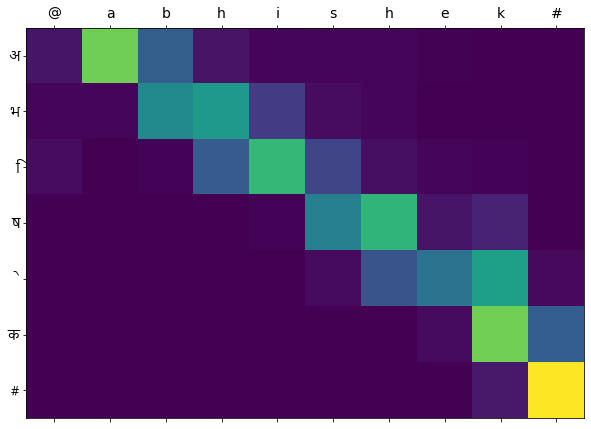

In [ ]:
translate("abhishek", enc, dec)

In [ ]:
def save_predictions(data_frame, name):
    accuracy_count = 0;
    with open(name, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["INPUT", "PREDICTION", "TRUE"])
        for i, (inp, trg) in enumerate(zip(data_frame[1], data_frame[0])): 
            result, sentence, attention_plot = evaluate(inp, enc, dec)
            if i < 20:
                attention_plot = attention_plot[:len(result), :len(sentence)]
                plot_attention(attention_plot, [i for i in sentence], [i for i in result], sentence, result)
            writer.writerow([inp, result[:-1], trg])
            print(inp, result[:-1], trg)
            if result[:-1] == trg:
                accuracy_count += 1
            if (i+1) % 100 == 0 or i+1 == data_frame.size:
                print("Accuracy", (accuracy_count / (i+1)))
                wandb.log({"attn test accuracy": (accuracy_count / (i+1))})

    return accuracy_count/data_frame.size

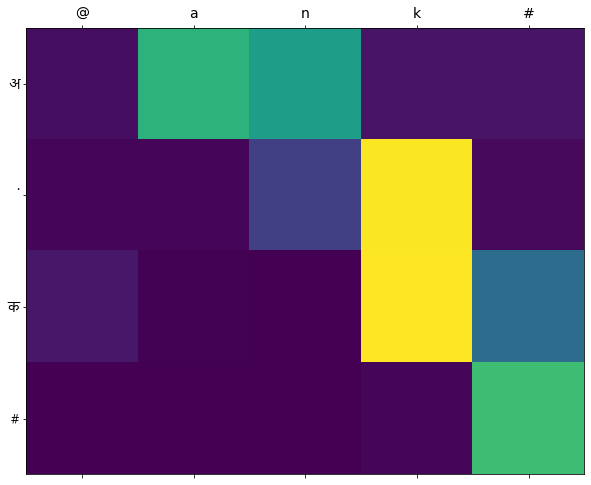

ank अंक अंक


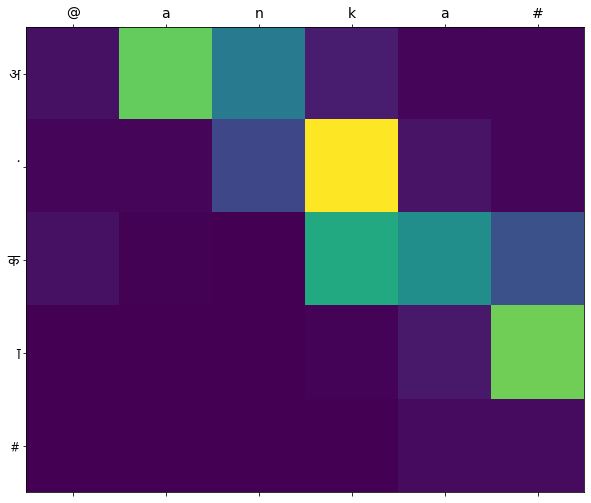

anka अंका अंक


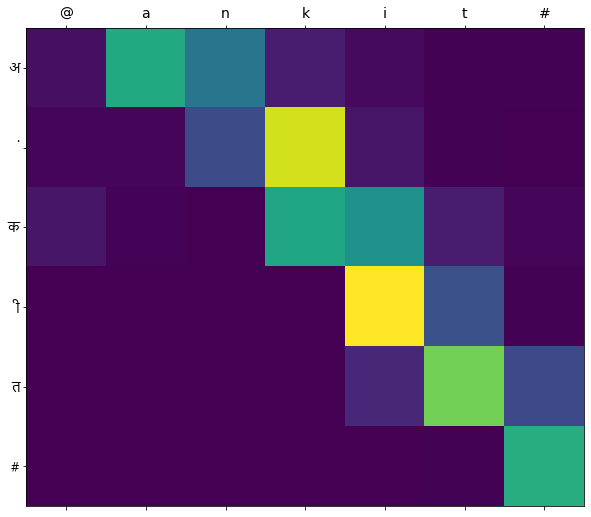

ankit अंकीत अंकित


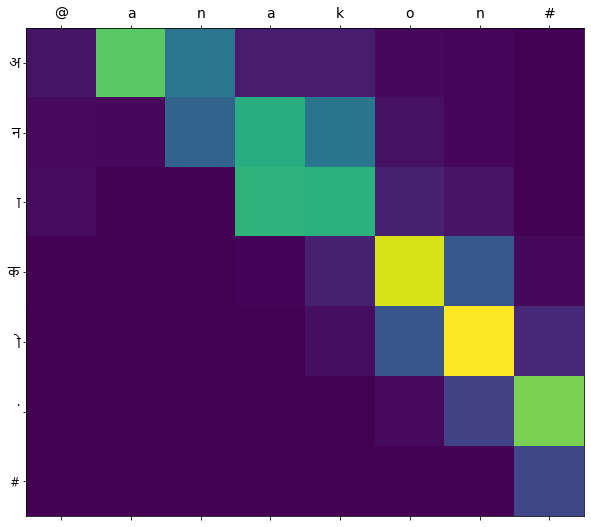

anakon अनाकों अंकों


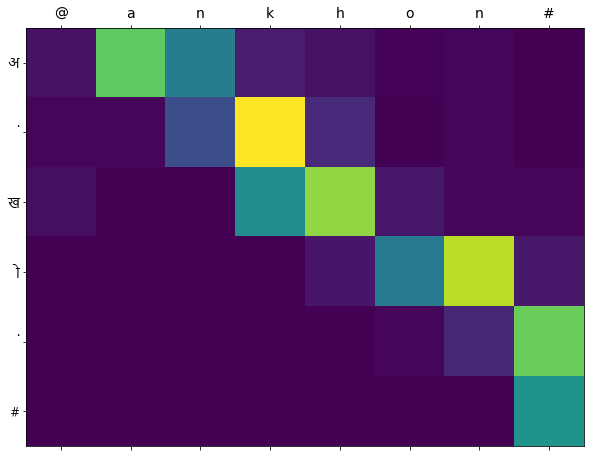

ankhon अंखों अंकों


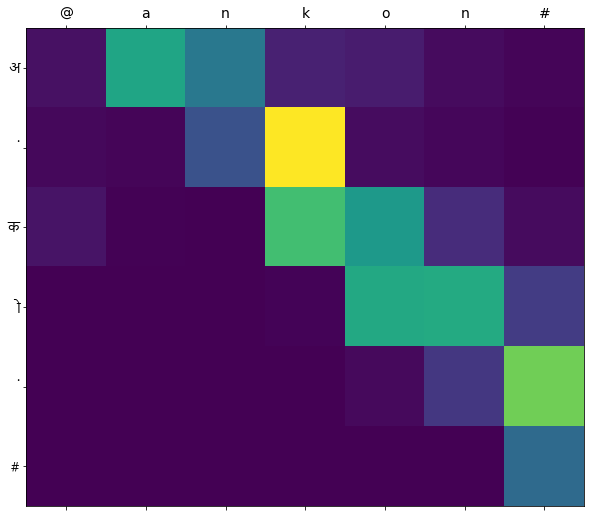

ankon अंकों अंकों


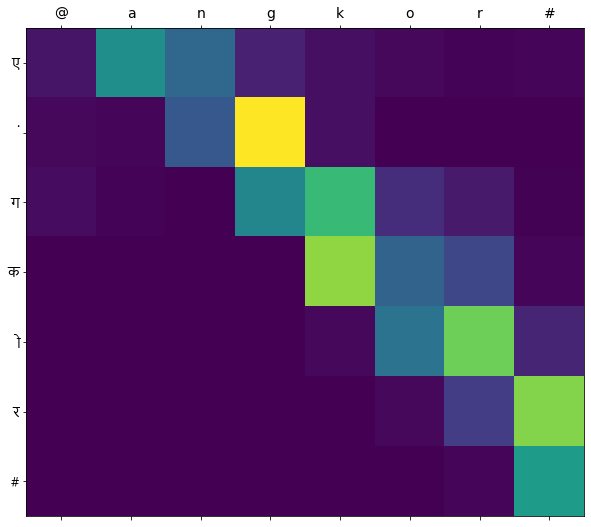

angkor एंगकोर अंकोर


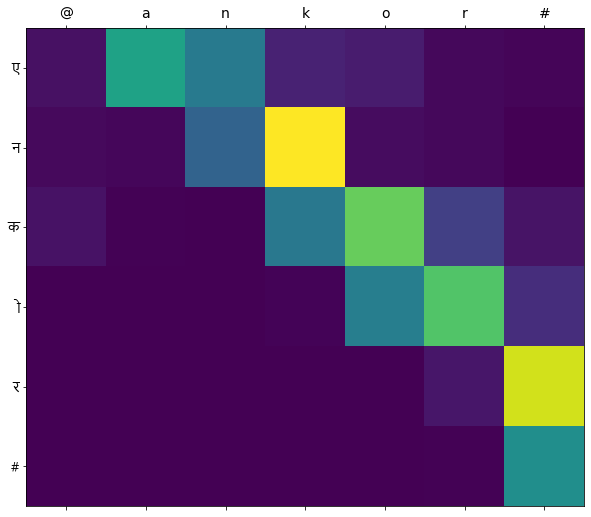

ankor एनकोर अंकोर


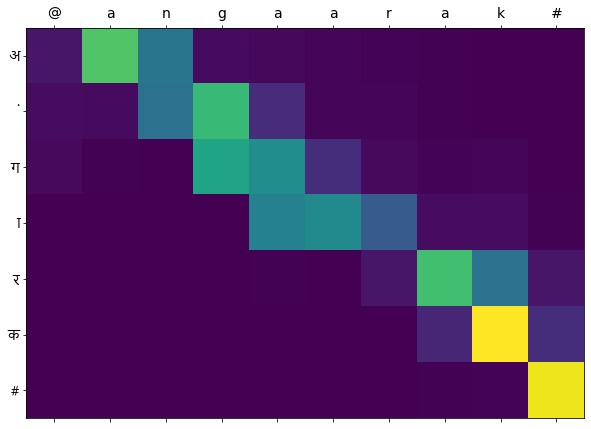

angaarak अंगारक अंगारक


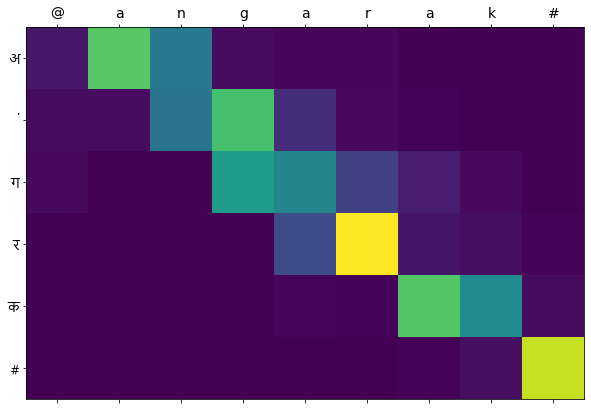

angarak अंगरक अंगारक


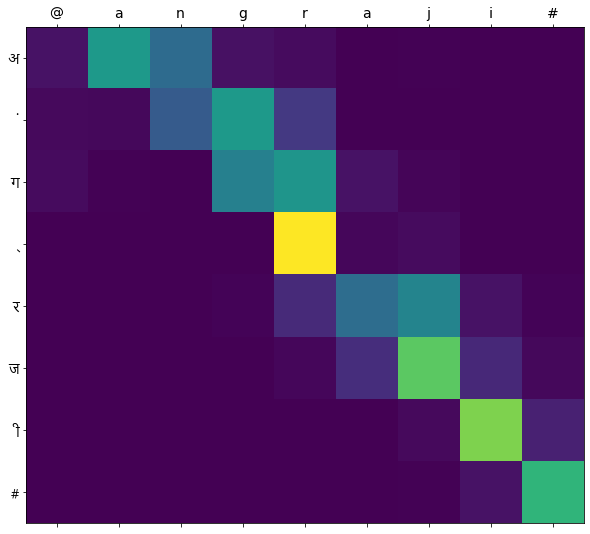

angraji अंग्रजी अंग्रज़ी


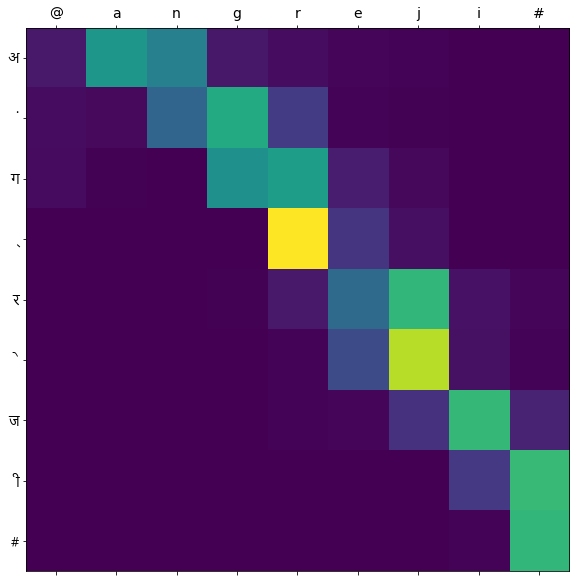

angreji अंग्रेजी अंग्रज़ी


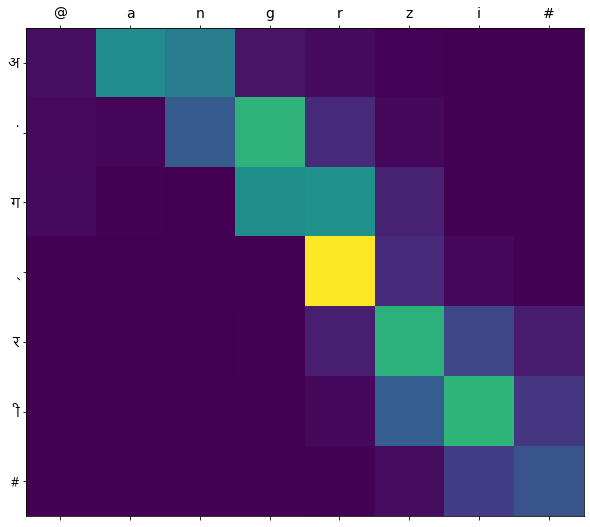

angrzi अंग्री अंग्रज़ी


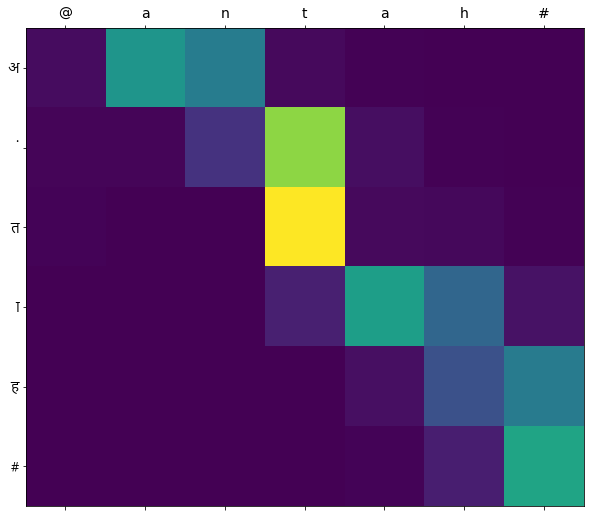

antah अंताह अंतः


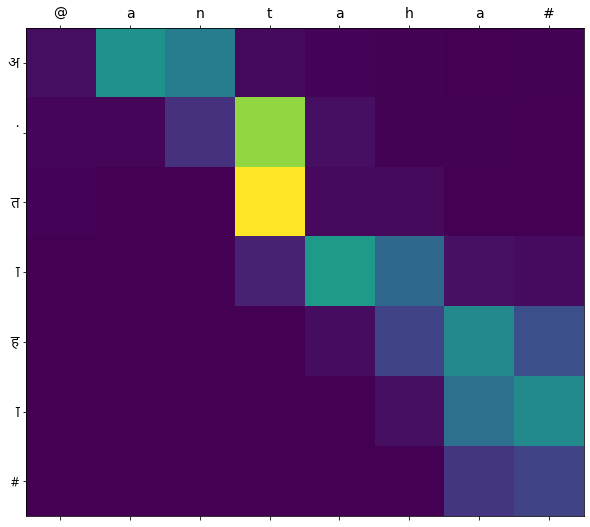

antaha अंताहा अंतः


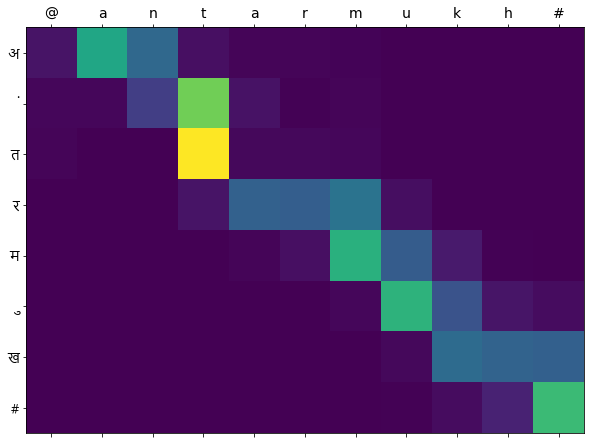

antarmukh अंतरमुख अंतर्मुख


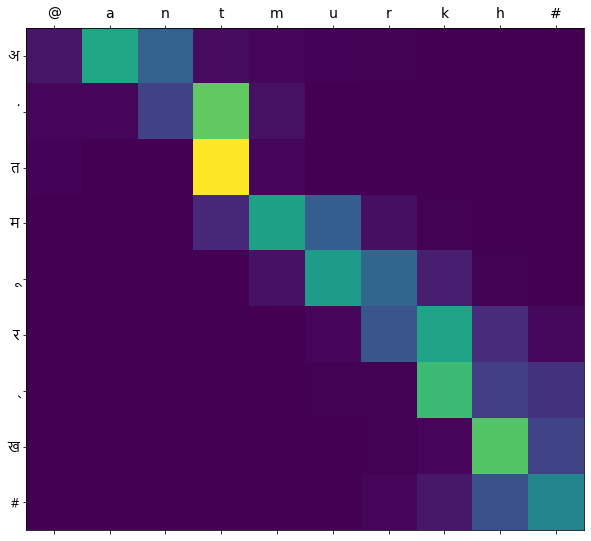

antmurkh अंतमूर्ख अंतर्मुख


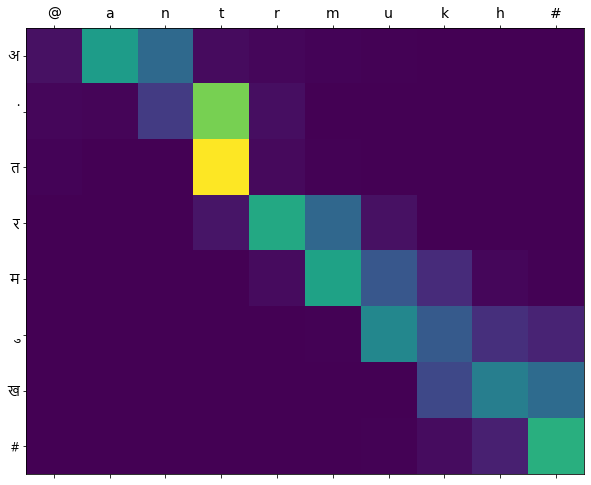

antrmukh अंतरमुख अंतर्मुख


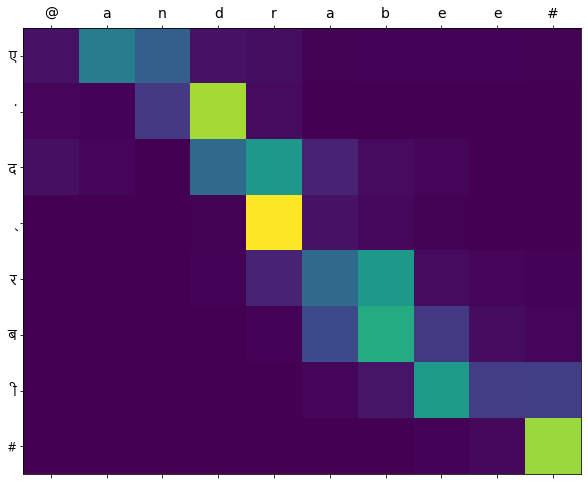

andrabee एंद्रबी अंद्राबी


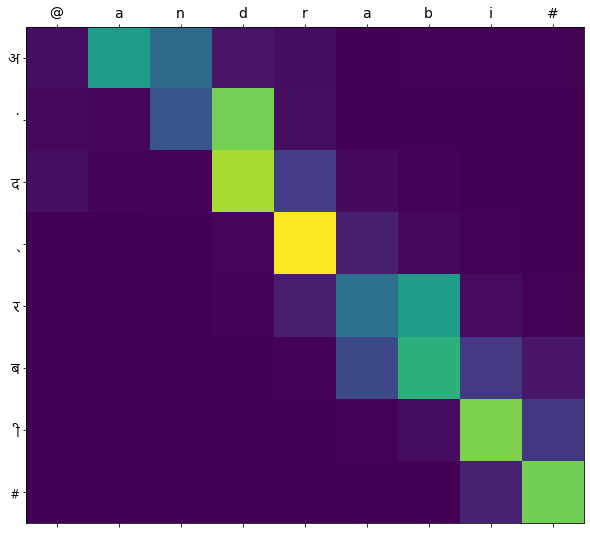

andrabi अंद्रबी अंद्राबी
andha अंधा अंधा
andhapan अंधपन अंधापन
andheri अंधेरी अंधेरी
ambaani अंबानी अंबानी
ambani अंबानी अंबानी
akram अक्रम अकरम
acapulco एकैपुल्स अकापुल्को
akapulko अकपूलकों अकापुल्को
akhand अखंड अखंड
akhil अखिल अखिल
agavai अगवाई अगवाई
agvaai अगवाई अगवाई
augustine ऑगस्टीन अगस्टाइन
augustustine ऑगस्टस अगस्टाइन
agsta अगस्ता अगस्ता
agusta अगुस्ता अगस्ता
augusta औगस्ता अगस्ता
agr एग्र अग्र
agra आग्रा अग्र
achambha अचंभा अचंभा
achanbha अचांभ अचंभा
achievement अछिवेमेंट अचीवमेंट
achivement अछिवेमेंट अचीवमेंट
acchi अच्ची अच्छी
achchi अच्छी अच्छी
achhi अछी अच्छी
achyut अछयुत अच्युत
achhanera अछानेरा अछनेरा
achnera अचनेरा अछनेरा
ajmeedh अजमीध अजमीढ़
ajhar अजहर अजहर
azhar अझार अजहर
ajit अजीत अजित
agnat अग्ञात अज्ञात
agyaat अज्ञात अज्ञात
agyat अज्ञात अज्ञात
atakta अटकता अटकता
atkata अटकता अटकता
atake आतके अटके
atke एटे अटके
atwaal आतवाल अटवाल
atwal आतवाल अटवाल
attahasa अटाहासा अट्टहास
atthaas आत्थास अट्टहास
atthas आत्थस अट्टहास
addon आद्दों अड्डों
athak अथक अथक
atharv अथार्व अथर्

0.13305197689915593

In [ ]:
save_predictions(test_df, "code_with_attn_predictions.csv")

**Visualiazation**

In [ ]:
# get html element
def cstr(s, color='black'):
	if s == ' ':
		return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
	else:
		return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)
	
# print html
def print_color(t):
	display(html_print(''.join([cstr(ti, color=ci) for ti,ci in t])))

# get appropriate color for value
# Darker shades of green denotes higher importance.
def get_clr(value):
	colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8',
		'#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
		'#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
		'#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
	value = int((value * 100) / 5)
	return colors[value]


def visualize(input_word, output_word, att_w):
  for i in range(len(output_word)):
    print("\nOutput character:", output_word[i], "\n")
    text_colours = []
    for j in range(len(att_w[i])):
      text = (input_word[j], get_clr(att_w[i][j]))
      text_colours.append(text)
    print_color(text_colours)

In [ ]:
# get appropriate color for value
# Darker shades of green denotes higher importance.
def get_shade_color(value):
	colors = ['#00fa00', '#00f500',  '#00eb00', '#00e000',  '#00db00',  
           '#00d100',  '#00c700',  '#00c200', '#00b800',  '#00ad00',  
           '#00a800',  '#009e00',  '#009400', '#008f00',  '#008500',
           '#007500',  '#007000',  '#006600', '#006100',  '#005c00',  
           '#005200',  '#004d00',  '#004700', '#003d00',  '#003800',  
           '#003300',  '#002900',  '#002400',  '#001f00',  '#001400']
	value = int((value * 100) / 5)
	return colors[value]

def connectivity(input_words,rnn_type,file_path):
  color_list=[]
  input_word_list=[]
  output_word_list=[]
  for k in range(3):
    output_word, input_word, _ ,att_w = inference_model(input_words[k],rnn_type)
    text_colours=[]
    for i in range(len(output_word)):
      colour=[]
      for j in range(len(att_w[i])):
        value=get_shade_color(att_w[i][j])
        colour.append(value)
      text_colours.append(colour)
    color_list.append(text_colours)
    input_word_list.append(input_word)
    output_word_list.append(output_word)
  create_file(color_list,input_word_list,output_word_list,file_path)

In [ ]:
def translate(sentence, encoder, decoder):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder)

    print('Input:', sentence)
    print('Predicted translation:', result)

    attention_plot = attention_plot[:len(result), :len(sentence)]
    plot_attention(attention_plot, [i for i in sentence], [i for i in result], sentence, result)
    #visualize(input_word, predicted_word, att_w)

Input: @abhishek#
Predicted translation: अभिशेक#


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


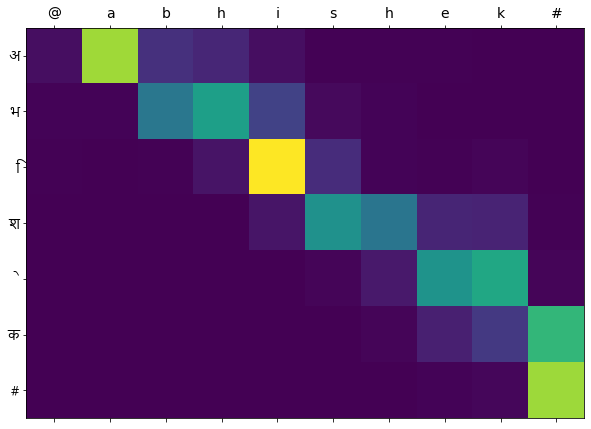

In [ ]:
translate("abhishek", enc, dec)